# Empirical Damage Calculations along Flowlines

The purpose of this notebook is to compute the damage using the Bassis & Ma 2015 evolution equation using along-flow observations at Thwaites glacier. In it, we consider how to approximate melt rates (we decide to exclude melt rate as observations are too sparse, resulting in a lower overall damage, but more interesting features), off-axis principal strain/stress (we opt to consider only along-flow to avoid complicating assumptions), and how to incorporate data with missing observations and smoothing really high resolution thickness (we use an interpolation function that assumes a gaussian smoothing kernel with paramters 2 and 6 (the former is the smallest value that fills all the NaNs, the latter gives a thickness with a scale of variation approximately consistent with a 2 km grid).

In [1]:
SAVEOUTPUT = False # To save the output in this notebook, you will need to create
                   # a results/ and figs/ directory

import os

import numpy as np
import matplotlib.pyplot as plt

import datetime
import matplotlib.colors as colors

from scipy.interpolate import RectBivariateSpline

import astropy.convolution

import h5py

%matplotlib inline

# CONSTANTS
RHOI = 918
RHOW = 1028
G = 9.81

A = 2.5e-17 # Pa^-3 yr^-1
GLENN = 3.


def dist_from_pts(arr):
    dists = np.r_[0,np.cumsum(np.sqrt(np.sum(np.diff(arr,axis=0)**2,axis=1)))]
    return dists

teis_cavity = -np.loadtxt('../data/flowlines/teis-cavity.interpolated.txt').T
teis_channel = -np.loadtxt('../data/flowlines/teis-channel.interpolated.txt').T
teis_gash = -np.loadtxt('../data/flowlines/teis-gash.interpolated.txt').T

flowlines = {'cavity':teis_cavity,
            'channel':teis_channel,
            'gash':teis_gash}

/home/skachuck/miniforge3/envs/python3/lib/python3.12/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
def iso2decimalyear(isodate):
    date = datetime.date.fromisoformat(isodate)
    start = datetime.date(date.year, 1, 1).toordinal()
    year_length = datetime.date(date.year+1, 1, 1).toordinal() - start
    return date.year + float(date.toordinal() - start) / year_length

def read_adrian_hov(fname):
    output = []
    with open(fname, 'r') as f:
        for line in f.readlines():
            line = line.strip('\n').split('\t')
            output.append([float(line[0]), float(line[2]), iso2decimalyear(line[1])])
    return np.array(output)


def collapse_duplicate_times(arr):
    """Take a (3,Nt,Nx) array where entry arr[2] is the times, and
    average duplicate time entries using nanmean.

    Returns (3,Nt',Nx) where each time is unique.
    """

    ts = arr[2][:,0]
    
    for i in np.where(np.diff(ts)==0)[0]:
        duplicate_time_nanmean = np.nanmean(np.vstack([arr[1][i], arr[1][i+1]]), axis=0)
        arr[1][i] = duplicate_time_nanmean.copy()
        arr[1][i+1] = duplicate_time_nanmean.copy()
    
    return arr[:,np.r_[0,np.where(np.diff(ts)!=0)[0]+1],:]

In [3]:
def bassis_ma_source(r, ps1s_flowline, thks_flowline,alpha,
                    uxs_flowline, mdots, mpd=True):
    """
    Compute incremental damage, dr, along a flowline, from initial damage r.

    Parameters
    ----------
    r - 
    ps1s_flowline - the strain rates along the flowline (in per annum)
    thks_flowline - ice thickness along the flowline (in m)
    alpha - the ratio of the first principal strain rate to the second
        alpha = 0 is a 1D flow (assumed)
        alpha = -1 is a shear-dominated 2D flow
        if all we know is values along a flowline, then we can only guess 
        at the transverse-ness of the principal strain-rate. We assume, 
        for simplicity, that the principal strain-rate is along-flow.
        
    uxs_flowline - velocities in m/day if mpd=True (default), otherwise km/yr
    mdots - melt rate (positive for melt, negative for accumulation) (in m/yr)

    atol - absolute tolerance for determining steady-state (default: 1e-7)
    return_conv - If True, return convergence data (default False)

    Returns
    -------
    r, rn - arrays with the length of thickess, velocity, and principal strain
            containing the steady-state damage and the Nye zero-stress damage
    """
    ps1s_flowline = ps1s_flowline + np.sign(ps1s_flowline)*1e-10 + 1e-10*(ps1s_flowline == 0)
    ps2s_flowline = alpha*ps1s_flowline

    if mpd:
        uxs_flowline = uxs_flowline*365.25/1000
    
    rho_i = 918
    rho_w = 1028
    g = 9.81
    
    A = 2.5e-17 # Pa^-3 yr^-1
    n = 3.
    ess_flowline = np.sqrt(0.5*(ps1s_flowline**2+ps2s_flowline**2))
    pt1s_flowline = A**(-1./GLENN)*ess_flowline**(1./GLENN - 1)*ps1s_flowline
    
    rn = np.maximum(0, np.minimum(1, RHOI/(RHOW-RHOI)*((2+alpha)*pt1s_flowline/(RHOI*G*thks_flowline + 1e-10))))
    s0 = RHOI*(RHOW-RHOI)/RHOW*G*thks_flowline/(2*pt1s_flowline + 1e-10)
    
    afac = 1 + alpha + alpha**2
    nstar = 4*GLENN*afac/(4*afac + 3*(GLENN-1)*alpha**2)
    fac = nstar*(1-s0)*ps1s_flowline + mdots/(thks_flowline+1e-10)
    
    dx = 0.1 # km

    
    udrdx = uxs_flowline*np.r_[0, (r[1:]-r[:-1])/dx]
    dr = fac*r - udrdx

    return dr, rn

def flowline_damage(ps1s_flowline, thks_flowline,alpha,
                    uxs_flowline, mdots,
                    atol=1e-7, return_conv=False, mpd=True):
    """
    Compute damage along a flowline, assuming steady state.

    Parameters
    ----------
    ps1s_flowline - the strain rates along the flowline (in per annum)
    thks_flowline - ice thickness along the flowline (in m)
    alpha - the ratio of the first principal strain rate to the second
        alpha = 0 is a 1D flow (assumed)
        alpha = -1 is a shear-dominated 2D flow
        if all we know is values along a flowline, then we can only guess 
        at the transverse-ness of the principal strain-rate. We assume, 
        for simplicity, that the principal strain-rate is along-flow.
        
    uxs_flowline - velocities in m/day if mpd=True (default), otherwise km/yr
    mdots - melt rate (positive for melt, negative for accumulation) (in m/yr)

    atol - absolute tolerance for determining steady-state (default: 1e-7)
    return_conv - If True, return convergence data (default False)

    Returns
    -------
    r, rn - arrays with the length of thickess, velocity, and principal strain
            containing the steady-state damage and the Nye zer-stress damage
    """
    if mpd:
        # change mpd to km/yr
        uxs_flowline = uxs_flowline*365.25/1000 # 365.25 days per year, to 
    
    # This guards against division-by-zero errors
    ps1s_flowline = ps1s_flowline + np.sign(ps1s_flowline)*1e-10 + 1e-10*(ps1s_flowline == 0)
    ps2s_flowline = alpha*ps1s_flowline
    
    ess_flowline = np.sqrt(0.5*(ps1s_flowline**2+ps2s_flowline**2))
    pt1s_flowline = A**(-1./GLENN)*ess_flowline**(1./GLENN - 1)*ps1s_flowline
    
    rn = np.maximum(0, np.minimum(1, RHOI/(RHOW-RHOI)*((2+alpha)*pt1s_flowline/(RHOI*G*thks_flowline + 1e-10))))
    
    imax = 1e5
    dx = .1                  # kilometers
    
    dt = np.min(dx/(uxs_flowline*1000)) # CFL Criterion, in years
    
    conv = []
    
    r = rn.copy()
    i = 0
    err = 1e30 # initialize error
    while err > atol:
        # This is an upwind derivative of damage for advection in meters
        # given velocities in km/yr
        dr, rn = bassis_ma_source(r, ps1s_flowline, thks_flowline,alpha,
                    uxs_flowline, mdots, mpd=False)
        # Keep the last step for comparison
        rnew = r + dr*dt
        rnew = np.maximum(rn, np.minimum(rnew,1))
        # Compute the mean step size
        rdiff = r - rnew
        err = np.abs(rdiff).mean()
        # Copy over the updated damage
        r = rnew.copy()
    
        if not i%100: conv.append(err)
        if i>imax: break
        i += 1
    if return_conv:
        return r, conv
    else:
        return r, rn

def hovmuller_damage(uxs, exxs, thks, sl_cut, alpha, mdots=None, return_nye=False):
    """
    Compute steady-state damage for array of velocity/principal strain-rates representing Nt times.

    uxs - Nt x Nx array of along-flow speeds
    exxs - Nt x Nx array of along flow strain-rates
    sl_cut - a numpy slice object to extract part of data, though went unused.
    alpha - the ratio of the first principal strain rate to the second
        alpha = 0 is a 1D flow (assumed)
        alpha = -1 is a shear-dominated 2D flow
        if all we know is values along a flowline, then we can only guess 
        at the transverse-ness of the principal strain-rate. We assume, 
        for simplicity, that the principal strain-rate is along-flow.

    mdots - melt rate (positive for melt, negative for accumulation) (in m/yr)
    return_nye - Flag to return array of Nye zero-stress damage (default False)

    Returns
    -------
    Nt x Nx array of steady state damages, and Nye zero-stress damage (if return_nye=True)
    """

    assert exxs.shape == uxs.shape, 'Strains and speeds must match'
    Nts, Nxs = exxs.shape
    assert len(thks) == Nxs, 'Strains, speeds, and thickness must match'

    thks_flowline = thks[sl_cut]


    rs_hov = np.zeros((Nts,Nxs))
    rn_hov = np.zeros((Nts,Nxs))
    
    for i in range(Nts):
        ps1s_flowline = exxs[i][sl_cut]
        uxs_flowline = uxs[i][sl_cut]

        if mdots is None:
            mdots = 0
        elif isinstance(mdots, np.ndarray):
            assert len(mdots)==len(uxs_flowline), 'mdots array must match length'
        # Can specify to use the divergence of the flux for the 
        elif isinstance(mdots, str):
            if mdots == 'divuh':
                mdots = -np.gradient(uxs_flowline*1000.*thks_flowline, 100)
            else:
                raise ValueError('Unrecognized mdots type')
        # Last try is to convert it to a float for constant melt
        else:
            mdots = float(mdots)

        rs, rn = flowline_damage(ps1s_flowline, thks_flowline,alpha,
                                uxs_flowline, mdots, atol=1e-7)
        rs_hov[i][sl_cut] = rs[:]
        rn_hov[i][sl_cut] = rn[:]

    if return_nye:
        return rs_hov, rn_hov
    else:
        return rs_hov

# Flowline Damage with no Thickness Advection, some tests

### Cavity

#### Loading fields and smoothing/filling experiments

In [4]:
exxs = read_adrian_hov('../data/hov_thwaites_new/hov.teis-cavity.quarterly_strains.txt').T.reshape((3,49,-1))
exxs = collapse_duplicate_times(exxs)
exxs_filled = astropy.convolution.interpolate_replace_nans(exxs[1], kernel=astropy.convolution.Gaussian2DKernel(6))

uxs = read_adrian_hov('../data/hov_thwaites_new/hov.teis-cavity.quarterly_speeds.txt').T.reshape((3,49,-1))
uxs = collapse_duplicate_times(uxs)
uxs_filled = astropy.convolution.interpolate_replace_nans(uxs[1], kernel=astropy.convolution.Gaussian2DKernel(6))

thks = np.genfromtxt('../data/hov_thwaites_new/CavC_Hofmoeller_geometry.csv', delimiter=',', skip_header=1)[:,4]

/tmp/ipykernel_7309/1204541251.py:26: RuntimeWarning: Mean of empty slice
  duplicate_time_nanmean = np.nanmean(np.vstack([arr[1][i], arr[1][i+1]]), axis=0)


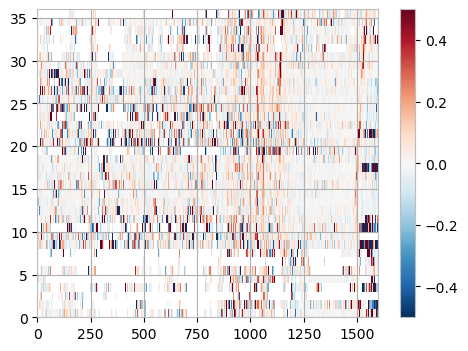

In [5]:
plt.pcolormesh(exxs[1]*1000, vmin=-0.5, vmax=0.5, cmap='RdBu_r'); plt.colorbar();

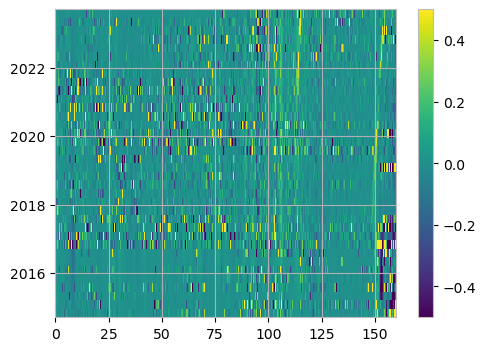

In [6]:
plt.pcolormesh(exxs[0], exxs[2], exxs_filled*1000, vmin=-0.5, vmax=0.5); plt.colorbar();

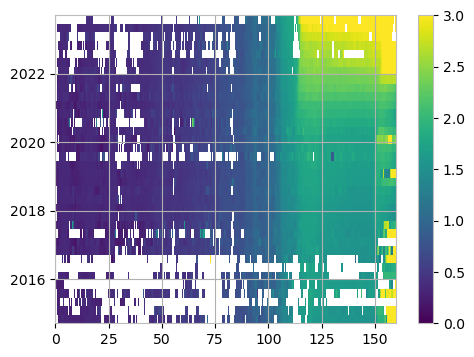

In [7]:
plt.pcolormesh(uxs[0], uxs[2], uxs[1],vmin=0,vmax=3); plt.colorbar();

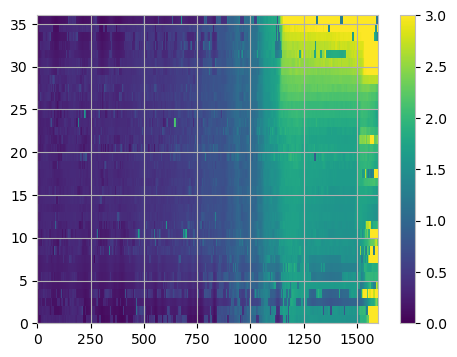

In [8]:
plt.pcolormesh(uxs_filled,vmin=0,vmax=3); plt.colorbar();

#### Cavity Results

/tmp/ipykernel_7309/1204541251.py:26: RuntimeWarning: Mean of empty slice
  duplicate_time_nanmean = np.nanmean(np.vstack([arr[1][i], arr[1][i+1]]), axis=0)


Text(0.5, 1.0, 'Cavity Gausssmooth 6')

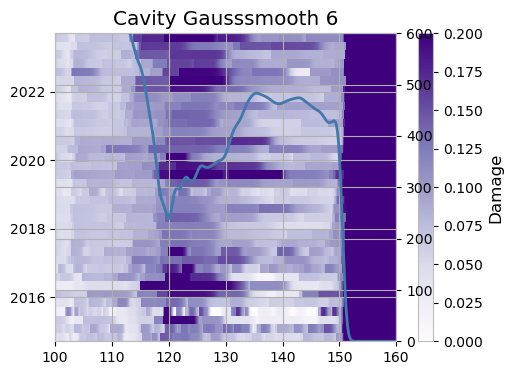

In [9]:
exxs = read_adrian_hov('../data/hov_thwaites_new/hov.teis-cavity.quarterly_strains.txt').T.reshape((3,49,-1))
exxs = collapse_duplicate_times(exxs)
exxs_filled = astropy.convolution.interpolate_replace_nans(exxs[1], kernel=astropy.convolution.Gaussian2DKernel(6))

uxs = read_adrian_hov('../data/hov_thwaites_new/hov.teis-cavity.quarterly_speeds.txt').T.reshape((3,49,-1))
uxs = collapse_duplicate_times(uxs)
uxs_filled = astropy.convolution.interpolate_replace_nans(uxs[1], kernel=astropy.convolution.Gaussian2DKernel(6))

thks = np.genfromtxt('../data/hov_thwaites_new/CavC_Hofmoeller_geometry.csv', delimiter=',', skip_header=1)[:,4]
thks_smooth = astropy.convolution.convolve(thks, kernel=astropy.convolution.Gaussian1DKernel(6))
if SAVEOUTPUT:
    np.savetxt('../results/CavC_Hofmoeller_geometry_gausssmooth6.txt', thks_smooth,
          header='CavC_Hofmoeller_geometry.csv smoothed using astropy Gaussian convolution with parameter 6')

cavity_dam, cavity_nye = hovmuller_damage(uxs_filled, exxs_filled, thks_smooth,
                                            np.s_[:], 0, return_nye=True)

if SAVEOUTPUT:
    np.savetxt('../results/cavity-A_2p5en17-mdot_0-alpha_0-hovthick_gausssmooth6.txt', np.dstack([uxs[0],uxs[2],cavity_dam,cavity_nye]).transpose((2,0,1)).reshape((4,-1)).T)

p = plt.pcolormesh(uxs[0], uxs[2], cavity_dam, vmin=0, vmax=0.2, cmap='Purples')
plt.colorbar(p, label='Damage')
plt.xlim([100, 160])
plt.twinx()
plt.plot(uxs[0][0],thks_smooth)
plt.ylim([0,600])
plt.title('Cavity Gausssmooth 6')

/tmp/ipykernel_7309/1204541251.py:26: RuntimeWarning: Mean of empty slice
  duplicate_time_nanmean = np.nanmean(np.vstack([arr[1][i], arr[1][i+1]]), axis=0)


Text(0.5, 1.0, 'Cavity Gausssmooth 2')

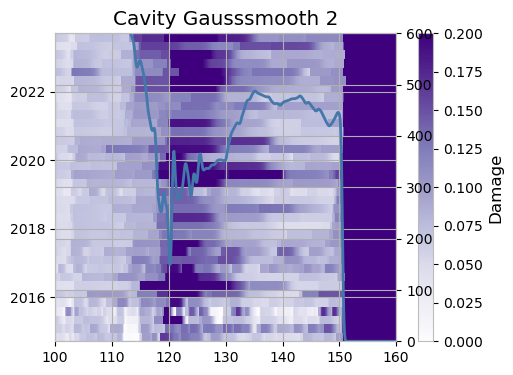

In [10]:
exxs = read_adrian_hov('../data/hov_thwaites_new/hov.teis-cavity.quarterly_strains.txt').T.reshape((3,49,-1))
exxs = collapse_duplicate_times(exxs)
exxs_filled = astropy.convolution.interpolate_replace_nans(exxs[1], kernel=astropy.convolution.Gaussian2DKernel(2))

uxs = read_adrian_hov('../data/hov_thwaites_new/hov.teis-cavity.quarterly_speeds.txt').T.reshape((3,49,-1))
uxs = collapse_duplicate_times(uxs)
uxs_filled = astropy.convolution.interpolate_replace_nans(uxs[1], kernel=astropy.convolution.Gaussian2DKernel(2))

thks = np.genfromtxt('../data/hov_thwaites_new/CavC_Hofmoeller_geometry.csv', delimiter=',', skip_header=1)[:,4]
thks_smooth = astropy.convolution.convolve(thks, kernel=astropy.convolution.Gaussian1DKernel(2))
if SAVEOUTPUT:
    np.savetxt('../results/CavC_Hofmoeller_geometry_gausssmooth2.txt', thks_smooth,
          header='CavC_Hofmoeller_geometry.csv smoothed using astropy Gaussian convolution with parameter 2')

cavity_dam, cavity_nye = hovmuller_damage(uxs_filled, exxs_filled, thks_smooth,
                                            np.s_[:], 0, return_nye=True)

if SAVEOUTPUT:
    np.savetxt('../results/cavity-A_2p5en17-mdot_0-alpha_0-hovthick_gausssmooth2.txt', np.dstack([uxs[0],uxs[2],cavity_dam,cavity_nye]).transpose((2,0,1)).reshape((4,-1)).T)

p = plt.pcolormesh(uxs[0], uxs[2], cavity_dam, vmin=0, vmax=0.2, cmap='Purples')
plt.colorbar(p, label='Damage')
plt.xlim([100, 160])
plt.twinx()
plt.plot(uxs[0][0],thks_smooth)
plt.ylim([0,600])
plt.title('Cavity Gausssmooth 2')

/tmp/ipykernel_7309/1204541251.py:26: RuntimeWarning: Mean of empty slice
  duplicate_time_nanmean = np.nanmean(np.vstack([arr[1][i], arr[1][i+1]]), axis=0)


Text(0.5, 1.0, 'Cavity NoSmooth')

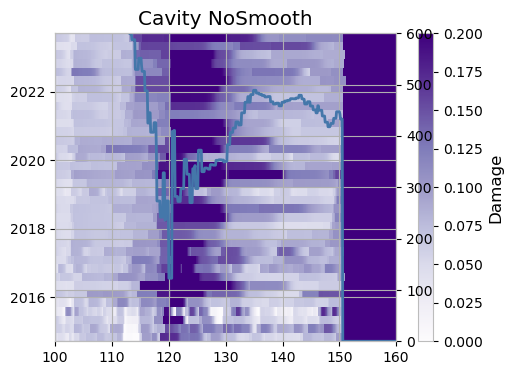

In [11]:
pts = flowlines['cavity']

exxs = read_adrian_hov('../data/hov_thwaites_new/hov.teis-cavity.quarterly_strains.txt').T.reshape((3,49,-1))
exxs = collapse_duplicate_times(exxs)
exxs_filled = astropy.convolution.interpolate_replace_nans(exxs[1], kernel=astropy.convolution.Gaussian2DKernel(2))

uxs = read_adrian_hov('../data/hov_thwaites_new/hov.teis-cavity.quarterly_speeds.txt').T.reshape((3,49,-1))
uxs = collapse_duplicate_times(uxs)
uxs_filled = astropy.convolution.interpolate_replace_nans(uxs[1], kernel=astropy.convolution.Gaussian2DKernel(2))
thks = np.genfromtxt('../data/hov_thwaites_new/CavC_Hofmoeller_geometry.csv', delimiter=',', skip_header=1)[:,4]
thks_smooth = astropy.convolution.convolve(thks, kernel=astropy.convolution.Gaussian1DKernel(6))

cavity_dam, cavity_nye = hovmuller_damage(uxs_filled, exxs_filled, thks,
                                            np.s_[:], 0, return_nye=True)

if SAVEOUTPUT:
    np.savetxt('../results/cavity-A_2p5en17-mdot_0-alpha_0-hovthick_nosmooth.txt', np.dstack([uxs[0],uxs[2],cavity_dam,cavity_nye]).transpose((2,0,1)).reshape((4,-1)).T)

p = plt.pcolormesh(uxs[0], uxs[2], cavity_dam, vmin=0, vmax=0.2, cmap='Purples')
plt.colorbar(p, label='Damage')
plt.xlim([100, 160])
plt.twinx()
plt.plot(uxs[0][0],thks)
plt.ylim([0,600])
plt.title('Cavity NoSmooth')

### Channel

#### Loading materials and Testing thickness smoothing

In [12]:
exxs = read_adrian_hov('../data/hov_thwaites_new/hov.teis-channel.quarterly_strains.txt').T.reshape((3,49,-1))
exxs_filled = astropy.convolution.interpolate_replace_nans(exxs[1], kernel=astropy.convolution.Gaussian2DKernel(2))

uxs = read_adrian_hov('../data/hov_thwaites_new/hov.teis-channel.quarterly_speeds.txt').T.reshape((3,49,-1))
uxs_filled = astropy.convolution.interpolate_replace_nans(uxs[1], kernel=astropy.convolution.Gaussian2DKernel(2))

thks = np.genfromtxt('../data/hov_thwaites_new/ChaC_Hofmoeller_geometry.csv', delimiter=',', skip_header=1)[:,4]

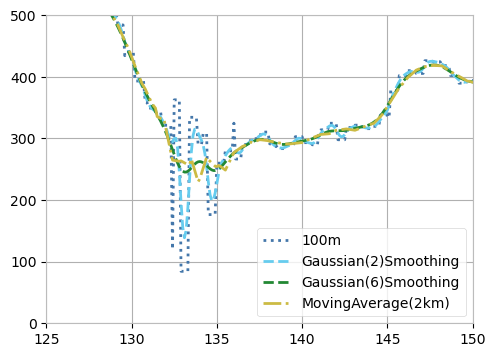

In [14]:
plt.plot(uxs[0][0], thks, ls=':', label='100m')
#plt.plot(uxs[0][0], thks)
plt.plot(uxs[0][0], astropy.convolution.convolve(thks, kernel=astropy.convolution.Gaussian1DKernel(2)), ls='--', label='Gaussian(2)Smoothing')
plt.plot(uxs[0][0], astropy.convolution.convolve(thks, kernel=astropy.convolution.Gaussian1DKernel(6)), ls='--', label='Gaussian(6)Smoothing')
plt.plot(uxs[0][0], np.convolve(thks, np.ones(20)/20, mode='same'), ls='-.', label='MovingAverage(2km)')
plt.xlim([125,150])
plt.ylim([0,500])
plt.legend()
if SAVEOUTPUT:
    plt.savefig('../figs/smoothing_comp.png', dpi=600)

#### Channel Results

/tmp/ipykernel_7309/1204541251.py:26: RuntimeWarning: Mean of empty slice
  duplicate_time_nanmean = np.nanmean(np.vstack([arr[1][i], arr[1][i+1]]), axis=0)


Text(0.5, 1.0, 'Channel NoSmooth')

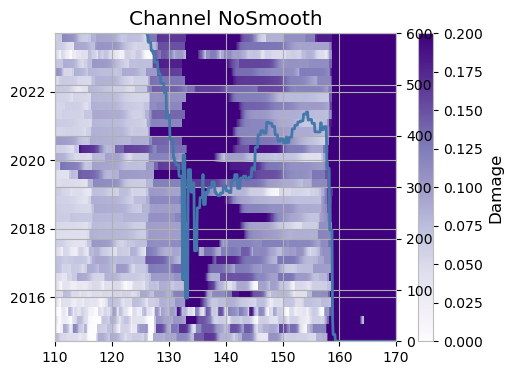

In [15]:
pts = flowlines['channel']

exxs = read_adrian_hov('../data/hov_thwaites_new/hov.teis-channel.quarterly_strains.txt').T.reshape((3,49,-1))
exxs = collapse_duplicate_times(exxs)
exxs_filled = astropy.convolution.interpolate_replace_nans(exxs[1], kernel=astropy.convolution.Gaussian2DKernel(2))

uxs = read_adrian_hov('../data/hov_thwaites_new/hov.teis-channel.quarterly_speeds.txt').T.reshape((3,49,-1))
uxs = collapse_duplicate_times(uxs)
uxs_filled = astropy.convolution.interpolate_replace_nans(uxs[1], kernel=astropy.convolution.Gaussian2DKernel(2))

thks = np.genfromtxt('../data/hov_thwaites_new/ChaC_Hofmoeller_geometry.csv', delimiter=',', skip_header=1)[:,4]

cavity_dam, cavity_nye = hovmuller_damage(uxs_filled, exxs_filled, thks,
                                            np.s_[:], 0, return_nye=True)

if SAVEOUTPUT:
    np.savetxt('../results/duplicatetimes/channel-A_2p5en17-mdot_0-alpha_0-hovthick_nosmooth.txt', np.dstack([uxs[0],uxs[2],cavity_dam,cavity_nye]).transpose((2,0,1)).reshape((4,-1)).T)

p = plt.pcolormesh(uxs[0], uxs[2], cavity_dam, vmin=0, vmax=0.2, cmap='Purples')
plt.colorbar(p, label='Damage')
plt.xlim([110, 170])
plt.twinx()
plt.plot(uxs[0][0],thks)
plt.ylim([0,600])
plt.title('Channel NoSmooth')

/tmp/ipykernel_7309/1204541251.py:26: RuntimeWarning: Mean of empty slice
  duplicate_time_nanmean = np.nanmean(np.vstack([arr[1][i], arr[1][i+1]]), axis=0)


Text(0.5, 1.0, 'Channel Gausssmooth6')

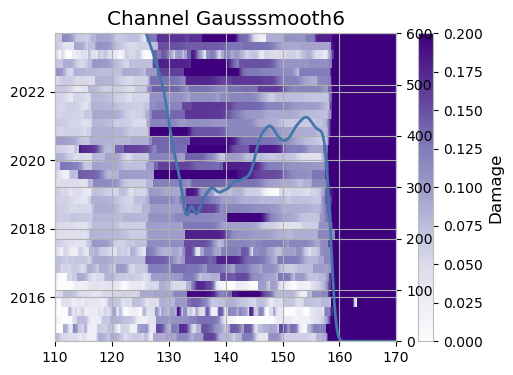

In [16]:
exxs = read_adrian_hov('../data/hov_thwaites_new/hov.teis-channel.quarterly_strains.txt').T.reshape((3,49,-1))
exxs = collapse_duplicate_times(exxs)
exxs_filled = astropy.convolution.interpolate_replace_nans(exxs[1], kernel=astropy.convolution.Gaussian2DKernel(6))

uxs = read_adrian_hov('../data/hov_thwaites_new/hov.teis-channel.quarterly_speeds.txt').T.reshape((3,49,-1))
uxs = collapse_duplicate_times(uxs)
uxs_filled = astropy.convolution.interpolate_replace_nans(uxs[1], kernel=astropy.convolution.Gaussian2DKernel(6))

thks = np.genfromtxt('../data/hov_thwaites_new/ChaC_Hofmoeller_geometry.csv', delimiter=',', skip_header=1)[:,4]
thks_smooth = astropy.convolution.convolve(thks, kernel=astropy.convolution.Gaussian1DKernel(6))
if SAVEOUTPUT:
    np.savetxt('../results/ChaC_Hofmoeller_geometry_gausssmooth6.txt', thks_smooth,
          header='ChaC_Hofmoeller_geometry.csv smoothed using astropy Gaussian convolution with parameter 6')

cavity_dam, cavity_nye = hovmuller_damage(uxs_filled, exxs_filled, thks_smooth,
                                            np.s_[:], 0, return_nye=True)

if SAVEOUTPUT:
    np.savetxt('../results/channel-A_2p5en17-mdot_0-alpha_0-hovthick_gausssmooth6.txt', np.dstack([uxs[0],uxs[2],cavity_dam,cavity_nye]).transpose((2,0,1)).reshape((4,-1)).T)

p = plt.pcolormesh(uxs[0], uxs[2], cavity_dam, vmin=0, vmax=0.2, cmap='Purples')
plt.colorbar(p, label='Damage')
plt.xlim([110, 170])
plt.twinx()
plt.plot(uxs[0][0],thks_smooth)
plt.ylim([0,600])
plt.title('Channel Gausssmooth6')

/tmp/ipykernel_7309/1204541251.py:26: RuntimeWarning: Mean of empty slice
  duplicate_time_nanmean = np.nanmean(np.vstack([arr[1][i], arr[1][i+1]]), axis=0)


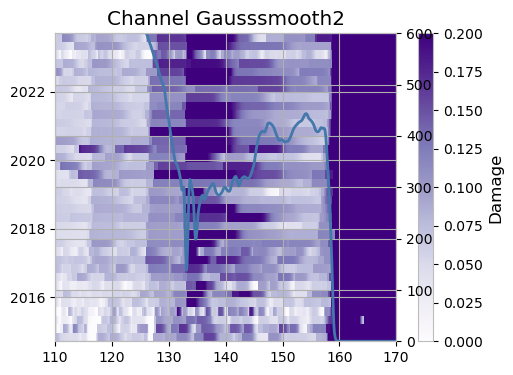

In [17]:
exxs = read_adrian_hov('../data/hov_thwaites_new/hov.teis-channel.quarterly_strains.txt').T.reshape((3,49,-1))
exxs = collapse_duplicate_times(exxs)
exxs_filled = astropy.convolution.interpolate_replace_nans(exxs[1], kernel=astropy.convolution.Gaussian2DKernel(2))

uxs = read_adrian_hov('../data/hov_thwaites_new/hov.teis-channel.quarterly_speeds.txt').T.reshape((3,49,-1))
uxs = collapse_duplicate_times(uxs)
uxs_filled = astropy.convolution.interpolate_replace_nans(uxs[1], kernel=astropy.convolution.Gaussian2DKernel(2))

thks = np.genfromtxt('../data/hov_thwaites_new/ChaC_Hofmoeller_geometry.csv', delimiter=',', skip_header=1)[:,4]
thks_smooth = astropy.convolution.convolve(thks, kernel=astropy.convolution.Gaussian1DKernel(2))
if SAVEOUTPUT:
    np.savetxt('../results/ChaC_Hofmoeller_geometry_gausssmooth2.txt', thks_smooth,
          header='ChaC_Hofmoeller_geometry.csv smoothed using astropy Gaussian convolution with parameter 2')

cavity_dam, cavity_nye = hovmuller_damage(uxs_filled, exxs_filled, thks_smooth,
                                            np.s_[:], 0, return_nye=True)

if SAVEOUTPUT:
    np.savetxt('../results/channel-A_2p5en17-mdot_0-alpha_0-hovthick_gausssmooth2.txt', np.dstack([uxs[0],uxs[2],cavity_dam,cavity_nye]).transpose((2,0,1)).reshape((4,-1)).T)

p = plt.pcolormesh(uxs[0], uxs[2], cavity_dam, vmin=0, vmax=0.2, cmap='Purples')
plt.colorbar(p, label='Damage')
plt.xlim([110, 170])
plt.twinx()
plt.plot(uxs[0][0],thks_smooth)
plt.ylim([0,600])
plt.title('Channel Gausssmooth2')

### Gash

/tmp/ipykernel_7309/1204541251.py:26: RuntimeWarning: Mean of empty slice
  duplicate_time_nanmean = np.nanmean(np.vstack([arr[1][i], arr[1][i+1]]), axis=0)


Text(0.5, 1.0, 'Gash Gausssmooth6')

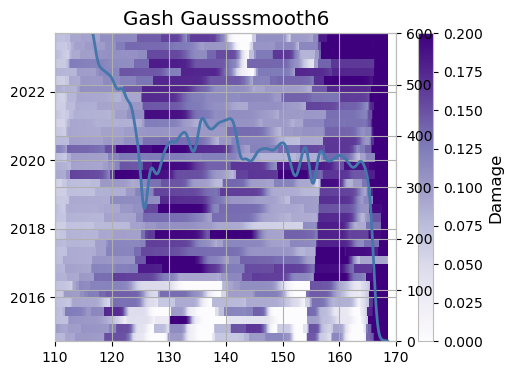

In [18]:
pts = flowlines['gash']

exxs = read_adrian_hov('../data/hov_thwaites_new/hov.teis-gash.quarterly_strains.txt').T.reshape((3,49,-1))
exxs = collapse_duplicate_times(exxs)
exxs_filled = astropy.convolution.interpolate_replace_nans(exxs[1], kernel=astropy.convolution.Gaussian2DKernel(6))

uxs = read_adrian_hov('../data/hov_thwaites_new/hov.teis-gash.quarterly_speeds.txt').T.reshape((3,49,-1))
uxs = collapse_duplicate_times(uxs)
uxs_filled = astropy.convolution.interpolate_replace_nans(uxs[1], kernel=astropy.convolution.Gaussian2DKernel(6))

thks = np.genfromtxt('../data/hov_thwaites_new/Gash_Hofmoeller_geometry.csv', delimiter=',', skip_header=1)[:,4]
thks_smooth = astropy.convolution.convolve(thks, kernel=astropy.convolution.Gaussian1DKernel(6))
if SAVEOUTPUT:
    np.savetxt('../results/Gash_Hofmoeller_geometry_gausssmooth6.txt', thks_smooth,
          header='Gash_Hofmoeller_geometry.csv smoothed using astropy Gaussian convolution with parameter 6')

gash_dam, gash_nye = hovmuller_damage(uxs_filled, exxs_filled, thks_smooth,
                                            np.s_[:], 0, return_nye=True)

if SAVEOUTPUT:
    np.savetxt('../results/gash-A_2p5en17-mdot_0-alpha_0-hovthick_gausssmooth6.txt', np.dstack([uxs[0],uxs[2],gash_dam,gash_nye]).transpose((2,0,1)).reshape((4,-1)).T)

p = plt.pcolormesh(uxs[0], uxs[2], gash_dam, vmin=0, vmax=0.2, cmap='Purples')
plt.colorbar(p, label='Damage')
plt.xlim([110, 170])
plt.twinx()
plt.plot(uxs[0][0],thks_smooth)
plt.ylim([0,600])
plt.title('Gash Gausssmooth6')

/tmp/ipykernel_7309/1204541251.py:26: RuntimeWarning: Mean of empty slice
  duplicate_time_nanmean = np.nanmean(np.vstack([arr[1][i], arr[1][i+1]]), axis=0)


Text(0.5, 1.0, 'Gash Gausssmooth2')

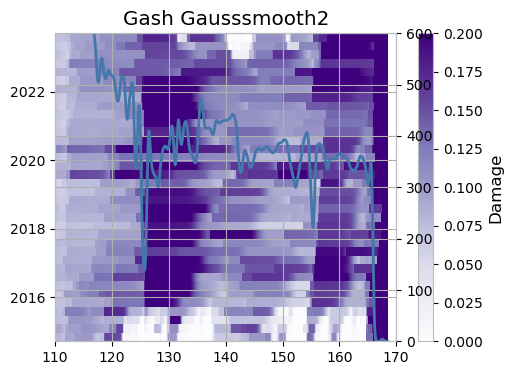

In [19]:
pts = flowlines['gash']

exxs = read_adrian_hov('../data/hov_thwaites_new/hov.teis-gash.quarterly_strains.txt').T.reshape((3,49,-1))
exxs = collapse_duplicate_times(exxs)
exxs_filled = astropy.convolution.interpolate_replace_nans(exxs[1], kernel=astropy.convolution.Gaussian2DKernel(2))

uxs = read_adrian_hov('../data/hov_thwaites_new/hov.teis-gash.quarterly_speeds.txt').T.reshape((3,49,-1))
uxs = collapse_duplicate_times(uxs)
uxs_filled = astropy.convolution.interpolate_replace_nans(uxs[1], kernel=astropy.convolution.Gaussian2DKernel(2))+1e-10


thks = np.genfromtxt('../data/hov_thwaites_new/Gash_Hofmoeller_geometry.csv', delimiter=',', skip_header=1)[:,4]
thks_smooth = astropy.convolution.convolve(thks, kernel=astropy.convolution.Gaussian1DKernel(2))
if SAVEOUTPUT:
    np.savetxt('../results/Gash_Hofmoeller_geometry_gausssmooth2.txt', thks_smooth,
          header='Gash_Hofmoeller_geometry.csv smoothed using astropy Gaussian convolution with parameter 2')

gash_dam, gash_nye = hovmuller_damage(uxs_filled, exxs_filled, thks_smooth,
                                            np.s_[:], 0, return_nye=True)

if SAVEOUTPUT:
    np.savetxt('../results/gash-A_2p5en17-mdot_0-alpha_0-hovthick_gausssmooth2.txt', np.dstack([uxs[0],uxs[2],gash_dam,gash_nye]).transpose((2,0,1)).reshape((4,-1)).T)

p = plt.pcolormesh(uxs[0], uxs[2], gash_dam, vmin=0, vmax=0.2, cmap='Purples')
plt.colorbar(p, label='Damage')
plt.xlim([110, 170])
plt.twinx()
plt.plot(uxs[0][0],thks_smooth)
plt.ylim([0,600])
plt.title('Gash Gausssmooth2')

/tmp/ipykernel_7309/1204541251.py:26: RuntimeWarning: Mean of empty slice
  duplicate_time_nanmean = np.nanmean(np.vstack([arr[1][i], arr[1][i+1]]), axis=0)


Text(0.5, 1.0, 'Gash NoSmooth')

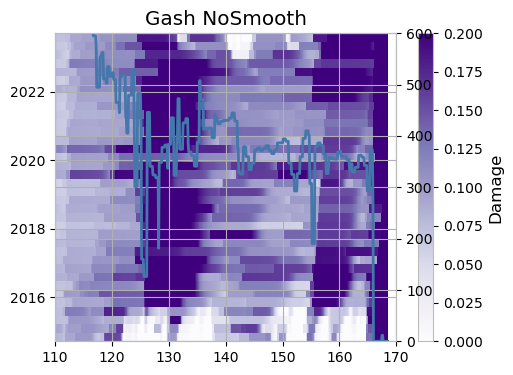

In [20]:
pts = flowlines['gash']

exxs = read_adrian_hov('../data/hov_thwaites_new/hov.teis-gash.quarterly_strains.txt').T.reshape((3,49,-1))
exxs = collapse_duplicate_times(exxs)
exxs_filled = astropy.convolution.interpolate_replace_nans(exxs[1], kernel=astropy.convolution.Gaussian2DKernel(2))

uxs = read_adrian_hov('../data/hov_thwaites_new/hov.teis-gash.quarterly_speeds.txt').T.reshape((3,49,-1))
uxs = collapse_duplicate_times(uxs)
uxs_filled = astropy.convolution.interpolate_replace_nans(uxs[1], kernel=astropy.convolution.Gaussian2DKernel(2))+1e-10

thks = np.genfromtxt('../data/hov_thwaites_new/Gash_Hofmoeller_geometry.csv', delimiter=',', skip_header=1)[:,4]
thks_smooth = astropy.convolution.convolve(thks, kernel=astropy.convolution.Gaussian1DKernel(2))

gash_dam, gash_nye = hovmuller_damage(uxs_filled, exxs_filled, thks,
                                            np.s_[:], 0, return_nye=True)

if SAVEOUTPUT:
    np.savetxt('../results/gash-A_2p5en17-mdot_0-alpha_0-hovthick_nosmooth.txt', np.dstack([uxs[0],uxs[2],gash_dam,gash_nye]).transpose((2,0,1)).reshape((4,-1)).T)

p = plt.pcolormesh(uxs[0], uxs[2], gash_dam, vmin=0, vmax=0.2, cmap='Purples')
plt.colorbar(p, label='Damage')
plt.xlim([110, 170])
plt.twinx()
plt.plot(uxs[0][0],thks)
plt.ylim([0,600])
plt.title('Gash NoSmooth')

# Mass Balance approach to Thickness Advection

We propose to advect the initial thickness using the observed velocities and strain-rates by computing mass balance along a flowline. Assuming the flowlines are stationary in time, thickness evolves according to $\frac{\partial h}{\partial t} + \nabla\cdot(uh) = -\dot{m}$.
We can expand the divergence flux as
$$\nabla\cdot(uh) = h\frac{\partial{u}}{\partial x} + u\frac{\partial{h}}{\partial x} = h\dot{\varepsilon}_{xx} + u\frac{\partial{h}}{\partial x}$$
which allows us to make better use of the derived strain rates. Putting this back in,
$$\frac{\partial h}{\partial t} = -\dot{m}-\left(h\dot{\varepsilon}_{xx} + u\frac{\partial{h}}{\partial x}\right)$$
We use a midpoint rule (between the timesteps) to compute the velocities

$$\mathbf{U}_{mid} = \frac{u_{i+1}+u_{i}}{2}$$
$$\mathbf{E}_{mid} = \frac{\varepsilon_{i+1}+\varepsilon_{i}}{2}$$

The explicit step for thicknesses yields
$$h_{i+1}=h_i-\Delta t\left[\dot{m}+\left(\mathbf{U}_{mid}\cdot\mathbf{D}+\mathbf{E}_{mid}\right)\cdot h_i\right]$$.

Similarly, the implicit step yields
$$h_{i+1}=h_i-\Delta t\left[\dot{m}+\left(\mathbf{U}_{mid}\cdot\mathbf{D}+\mathbf{E}_{mid}\right)\cdot h_{i+1}\right]$$
$$h_{i+1}+\Delta t\left(\mathbf{U}_{mid}\cdot\mathbf{D}+\mathbf{E}_{mid}\right)\cdot h_{i+1}=h_i-\dot{m}\Delta t$$
$$\left(\mathcal{I}+\Delta t\left(\mathbf{U}_{mid}\cdot\mathbf{D}+\mathbf{E}_{mid}\right)\right)\cdot h_{i+1}=h_i-\dot{m}\Delta t .$$

We are going to use the implicit step, with an upwind derivative, to maximize numerical stability, although the ingredients are in the function below to make different choices.

## Advecting a Flowline thickness

In [21]:
def evolve_thickess(h0, ux, exx, xs, ts, mpd=True, melt=0):
    """Evolve thicknesses using a mass-balance equation, given initial thickness,
    and strain-rates and speeds (assuming speeds are in meters per day).

    h0 is initial thickness, m
    ux are the speeds over time in m/day (mpd=True) or km/yr
    exx are strain rates in per year

    positive melt implies thickness loss
    
    """
    thks = np.zeros_like(ux)
    thks[0] = h0.copy()

    if mpd:
        # convert m/day to km/yr
        ux = ux*365.25/1000
    
    for i, dt in enumerate(np.diff(ts)):
        ux_mid = (ux[i+1] + ux[i])/2
        exx_mid = (exx[i+1] + exx[i])/2

        # Forward step
        #h_grad = np.gradient(thks[i], xs)
        #dhdt = -(thks[i]*exx_mid + ux_mid*h_grad)
        #thks[i+1] = thks[i] + dhdt*dt
        
        # Backward step
        # Centered derivative
        dx = np.diff(xs)[0]
        D = (np.diag(np.ones(len(thks_smooth)-1), k=1)-np.diag(np.ones(len(thks_smooth)-1), k=-1))/2/dx
        D[0,0]=-1./dx
        D[0,1]=1./dx
        D[-1,-1]=1./dx
        D[-1,-2]=-1./dx


        # Upwind derivative
        dx = np.diff(xs)[0]
        D = (np.diag(np.ones(len(thks_smooth)-1), k=1)-np.diag(np.ones(len(thks_smooth)-1), k=-1))/dx
        D = (np.diag(np.ones(len(thks_smooth)))-np.diag(np.ones(len(thks_smooth)-1), k=-1))/dx
        D[0,0]=0           # no flux boundary
        
        A = np.identity(len(xs))+dt*(np.diag(ux_mid).dot(D)+np.diag(exx_mid))
        thks[i+1] = np.linalg.inv(A).dot(thks[i]-dt*melt)
        
    return thks
        

### Testing advection

In [22]:
exxs = read_adrian_hov('../data/hov_thwaites_new/hov.teis-cavity.quarterly_strains.txt').T.reshape((3,49,-1))
exxs = collapse_duplicate_times(exxs)
exxs_filled = astropy.convolution.interpolate_replace_nans(exxs[1], kernel=astropy.convolution.Gaussian2DKernel(2))

uxs = read_adrian_hov('../data/hov_thwaites_new/hov.teis-cavity.quarterly_speeds.txt').T.reshape((3,49,-1))
uxs = collapse_duplicate_times(uxs)
uxs_filled = astropy.convolution.interpolate_replace_nans(uxs[1], kernel=astropy.convolution.Gaussian2DKernel(2))

thks = np.genfromtxt('../data/hov_thwaites_new/CavC_Hofmoeller_geometry.csv', delimiter=',', skip_header=1)[:,4]
thks_smooth = astropy.convolution.convolve(thks, kernel=astropy.convolution.Gaussian1DKernel(2))

# Distances in km
xs = uxs[0][0]
# Times in decimal year
ts = uxs[2][:,0]

/tmp/ipykernel_7309/1204541251.py:26: RuntimeWarning: Mean of empty slice
  duplicate_time_nanmean = np.nanmean(np.vstack([arr[1][i], arr[1][i+1]]), axis=0)


In [23]:
thks_over_time = evolve_thickess(thks_smooth, uxs_filled, exxs_filled, xs, ts)

(110.0, 160.0)

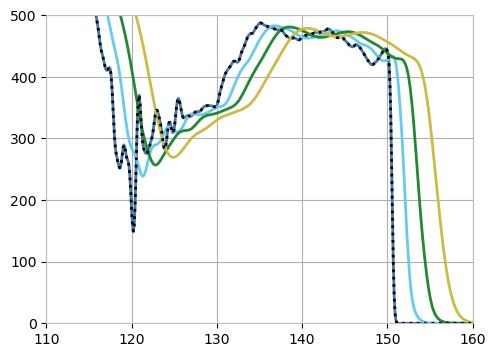

In [24]:
plt.plot(xs, thks_over_time[::10].T)
plt.plot(xs, thks_smooth, ls=':', c='k')
plt.ylim([0,500])
plt.xlim([110,160])

## Computing Damage along advected flowline

We'll compute damage along the flowlines. First, by computing the steady-state damage predictions at successive thicknesses, and second using a transient, advected evolution at the successive thicknesses, starting in steady state at t=0. 

#### Cavity

In [25]:
pts = flowlines['cavity']

exxs = read_adrian_hov('../data/hov_thwaites_new/hov.teis-cavity.quarterly_strains.txt').T.reshape((3,49,-1))
exxs = collapse_duplicate_times(exxs)
exxs_filled = astropy.convolution.interpolate_replace_nans(exxs[1], kernel=astropy.convolution.Gaussian2DKernel(6))

uxs = read_adrian_hov('../data/hov_thwaites_new/hov.teis-cavity.quarterly_speeds.txt').T.reshape((3,49,-1))
uxs = collapse_duplicate_times(uxs)
uxs_filled = astropy.convolution.interpolate_replace_nans(uxs[1], kernel=astropy.convolution.Gaussian2DKernel(6))

# Distances in km
xs = uxs[0][0]
# Times in decimal year
ts = uxs[2][:,0]

thks = np.genfromtxt('../data/hov_thwaites_new/CavC_Hofmoeller_geometry.csv', delimiter=',', skip_header=1)[:,4]
thks_smooth = astropy.convolution.convolve(thks, kernel=astropy.convolution.Gaussian1DKernel(6))

thks_over_time = evolve_thickess(thks_smooth, uxs_filled, exxs_filled, xs, ts)

/tmp/ipykernel_7309/1204541251.py:26: RuntimeWarning: Mean of empty slice
  duplicate_time_nanmean = np.nanmean(np.vstack([arr[1][i], arr[1][i+1]]), axis=0)


In [26]:
dx = 0.1

# Steady state damages and Nye zero-stress damages
r_ss = np.zeros_like(thks_over_time)
rn_ss = np.zeros_like(thks_over_time)
# Incremented damages and Nye zero-stress damages
rn_t = np.zeros_like(thks_over_time)
r_t = np.zeros_like(thks_over_time)

# Iterate through timeseries
for i, deltat in enumerate(np.diff(ts)):
    # Compute the steady-state damage in the new thickness configuration, etc.
    r_ss[i], rn_ss[i] = flowline_damage(exxs_filled[i], thks_over_time[i],0,
                    uxs_filled[i], 0,
                    atol=1e-7, return_conv=False)


    # Timeseries (non steady state) damage evolution
    # On first time step, set initial incremented damage with SS
    if i==0: 
        r_t[0] = r_ss[0]
        rn_t[0] = rn_ss[0]
        continue

    # Use midpoint rule through timestep
    ux_mid = (uxs_filled[i] + uxs_filled[i-1])/2
    exx_mid = (exxs_filled[i] + exxs_filled[i-1])/2
    thk_mid = (thks_over_time[i] + thks_over_time[i-1])/2
    # 
    r_intermediate = r_t[i-1].copy()
    dt_cfl = np.min(dx/(ux_mid*365.25/1000)/2.) # CFL Criterion
    # number of steps consistent with CFL Criterion
    isteps = np.ceil(deltat / dt_cfl)
    # timestep consistent with CFL Criterion
    dt = deltat / isteps
    assert dt <= dt_cfl
    for j in range(int(isteps)):
        dr, rn_t[i] = bassis_ma_source(r_intermediate, exx_mid, thk_mid,0,
                            ux_mid, 0)
        r_intermediate = np.maximum(rn_t[i], np.minimum(r_intermediate+dr*dt,1))
    r_t[i] = r_intermediate.copy()

if SAVEOUTPUT:
    np.savetxt('../results/cavity-A_2p5en17-mdot_0-alpha_0-hovthick_gausssmooth6-advect_thick.txt', 
           np.dstack([uxs[0],uxs[2],r_ss,r_t,rn_ss,thks_over_time]).transpose((2,0,1)).reshape((6,-1)).T,
           header='Date\tDistance\tSteadyStateDam\tTransientDam\tNyeDamage\tThickness')


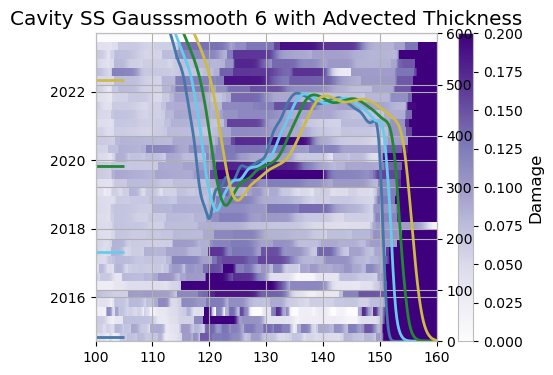

In [27]:
p = plt.pcolormesh(uxs[0], uxs[2], r_ss, vmin=0, vmax=0.2, cmap='Purples')
#plt.axvline(1278, c='k', alpha=0.1)
#plt.pcolormesh(np.isnan(exxs[1]), cmap=colors.ListedColormap([(0,0,0,0), (0,0,0,.2)]));
plt.colorbar(p, label='Damage')
plt.xlim([100, 160])

for t, c in zip(ts[::10], ['#4477aa', '#66ccee', '#228833', '#ccbb44', '#ee6677', '#aa3377', '#bbbbbb']):
    plt.hlines(t,100, 105, color=c)
plt.twinx()
plt.plot(uxs[0][0], thks_over_time[::10].T)
plt.ylim([0,600])
plt.title('Cavity SS Gausssmooth 6 with Advected Thickness')

if SAVEOUTPUT:
    plt.savefig('../figs/cavity-A_2p5en17-mdot_0-alpha_0-gausssmooth6-steadystate-advect_thick.png', dpi=600)

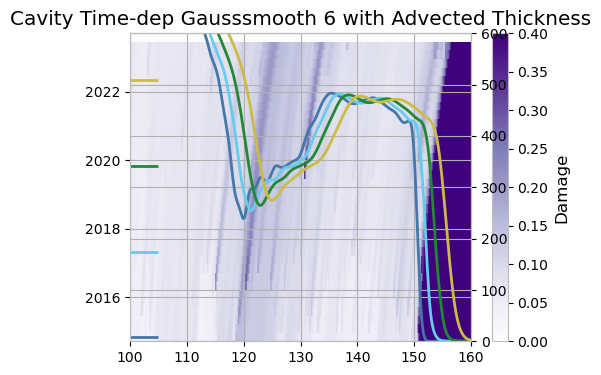

In [28]:
p = plt.pcolormesh(uxs[0], uxs[2], r_t, vmin=0, vmax=0.4, cmap='Purples')
#plt.axvline(1278, c='k', alpha=0.1)
#plt.pcolormesh(np.isnan(exxs[1]), cmap=colors.ListedColormap([(0,0,0,0), (0,0,0,.2)]));
plt.colorbar(p, label='Damage')
plt.xlim([100, 160])

for t, c in zip(ts[::10], ['#4477aa', '#66ccee', '#228833', '#ccbb44', '#ee6677', '#aa3377', '#bbbbbb']):
    plt.hlines(t,100, 105, color=c)

plt.twinx()
plt.plot(uxs[0][0], thks_over_time[::10].T)
plt.ylim([0,600])
plt.title('Cavity Time-dep Gausssmooth 6 with Advected Thickness')
if SAVEOUTPUT:
    plt.savefig('../figs/cavity-A_2p5en17-mdot_0-alpha_0-gausssmooth6-transient-advect_thick.png', dpi=600)

#### Channel

In [29]:
pts = flowlines['channel']

exxs = read_adrian_hov('../data/hov_thwaites_new/hov.teis-channel.quarterly_strains.txt').T.reshape((3,49,-1))
exxs = collapse_duplicate_times(exxs)
exxs_filled = astropy.convolution.interpolate_replace_nans(exxs[1], kernel=astropy.convolution.Gaussian2DKernel(6))

uxs = read_adrian_hov('../data/hov_thwaites_new/hov.teis-channel.quarterly_speeds.txt').T.reshape((3,49,-1))
uxs = collapse_duplicate_times(uxs)
uxs_filled = astropy.convolution.interpolate_replace_nans(uxs[1], kernel=astropy.convolution.Gaussian2DKernel(6))

# Distances in km
xs = uxs[0][0]
# Times in decimal year
ts = uxs[2][:,0]

thks = np.genfromtxt('../data/hov_thwaites_new/ChaC_Hofmoeller_geometry.csv', delimiter=',', skip_header=1)[:,4]
thks_smooth = astropy.convolution.convolve(thks, kernel=astropy.convolution.Gaussian1DKernel(6))

thks_over_time = evolve_thickess(thks_smooth, uxs_filled, exxs_filled, xs, ts)

/tmp/ipykernel_7309/1204541251.py:26: RuntimeWarning: Mean of empty slice
  duplicate_time_nanmean = np.nanmean(np.vstack([arr[1][i], arr[1][i+1]]), axis=0)


In [30]:
dx = 0.1

# Steady state damages and Nye zero-stress damages
r_ss = np.zeros_like(thks_over_time)
rn_ss = np.zeros_like(thks_over_time)
# Incremented damages and Nye zero-stress damages
rn_t = np.zeros_like(thks_over_time)
r_t = np.zeros_like(thks_over_time)

# Iterate through timeseries
for i, deltat in enumerate(np.diff(ts)):
    # Compute the steady-state damage in the new thickness configuration, etc.
    r_ss[i], rn_ss[i] = flowline_damage(exxs_filled[i], thks_over_time[i],0,
                    uxs_filled[i], 0,
                    atol=1e-7, return_conv=False)


    # Timeseries (non steady state) damage evolution
    # On first time step, set initial incremented damage with SS
    if i==0: 
        r_t[0] = r_ss[0]
        rn_t[0] = rn_ss[0]
        continue

    # Use midpoint rule through timestep
    ux_mid = (uxs_filled[i] + uxs_filled[i-1])/2
    exx_mid = (exxs_filled[i] + exxs_filled[i-1])/2
    thk_mid = (thks_over_time[i] + thks_over_time[i-1])/2
    # 
    r_intermediate = r_t[i-1].copy()
    dt_cfl = np.min(dx/(ux_mid*365.25/1000)/2.) # CFL Criterion
    # number of steps consistent with CFL Criterion
    isteps = np.ceil(deltat / dt_cfl)
    # timestep consistent with CFL Criterion
    dt = deltat / isteps
    assert dt <= dt_cfl
    for j in range(int(isteps)):
        dr, rn_t[i] = bassis_ma_source(r_intermediate, exx_mid, thk_mid,0,
                            ux_mid, 0)
        r_intermediate = np.maximum(rn_t[i], np.minimum(r_intermediate+dr*dt,1))
    r_t[i] = r_intermediate.copy()

if SAVEOUTPUT:
    np.savetxt('../results/channel-A_2p5en17-mdot_0-alpha_0-hovthick_gausssmooth6-advect_thick.txt', 
           np.dstack([uxs[0],uxs[2],r_ss,r_t,rn_ss,thks_over_time]).transpose((2,0,1)).reshape((6,-1)).T,
           header='Date\tDistance\tSteadyStateDam\tTransientDam\tNyeDamage\tThickness')


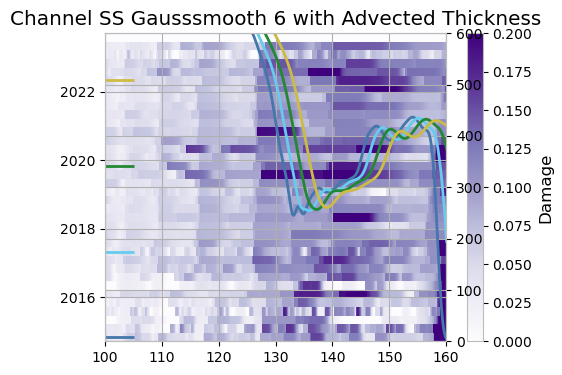

In [31]:
p = plt.pcolormesh(uxs[0], uxs[2], r_ss, vmin=0, vmax=0.2, cmap='Purples')
#plt.axvline(1278, c='k', alpha=0.1)
#plt.pcolormesh(np.isnan(exxs[1]), cmap=colors.ListedColormap([(0,0,0,0), (0,0,0,.2)]));
plt.colorbar(p, label='Damage')
plt.xlim([100, 160])

for t, c in zip(ts[::10], ['#4477aa', '#66ccee', '#228833', '#ccbb44', '#ee6677', '#aa3377', '#bbbbbb']):
    plt.hlines(t,100, 105, color=c)
plt.twinx()
plt.plot(uxs[0][0], thks_over_time[::10].T)
plt.ylim([0,600])
plt.title('Channel SS Gausssmooth 6 with Advected Thickness')

if SAVEOUTPUT:
    plt.savefig('../figs/channel-A_2p5en17-mdot_0-alpha_0-gausssmooth6-steadystate-advect_thick.png', dpi=600)

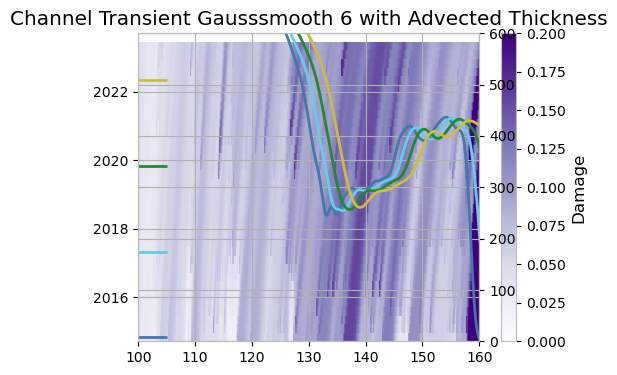

In [32]:
p = plt.pcolormesh(uxs[0], uxs[2], r_t, vmin=0, vmax=0.2, cmap='Purples')
#plt.axvline(1278, c='k', alpha=0.1)
#plt.pcolormesh(np.isnan(exxs[1]), cmap=colors.ListedColormap([(0,0,0,0), (0,0,0,.2)]));
plt.colorbar(p, label='Damage')
plt.xlim([100, 160])

for t, c in zip(ts[::10], ['#4477aa', '#66ccee', '#228833', '#ccbb44', '#ee6677', '#aa3377', '#bbbbbb']):
    plt.hlines(t,100, 105, color=c)

plt.twinx()
plt.plot(uxs[0][0], thks_over_time[::10].T)
plt.ylim([0,600])
plt.title('Channel Transient Gausssmooth 6 with Advected Thickness')
if SAVEOUTPUT:
    plt.savefig('../figs/channel-A_2p5en17-mdot_0-alpha_0-gausssmooth6-transient-advect_thick.png', dpi=600)

#### Gash

In [33]:
pts = flowlines['gash']

exxs = read_adrian_hov('../data/hov_thwaites_new/hov.teis-gash.quarterly_strains.txt').T.reshape((3,49,-1))
exxs = collapse_duplicate_times(exxs)
exxs_filled = astropy.convolution.interpolate_replace_nans(exxs[1], kernel=astropy.convolution.Gaussian2DKernel(6))

uxs = read_adrian_hov('../data/hov_thwaites_new/hov.teis-gash.quarterly_speeds.txt').T.reshape((3,49,-1))
uxs = collapse_duplicate_times(uxs)
uxs_filled = astropy.convolution.interpolate_replace_nans(uxs[1], kernel=astropy.convolution.Gaussian2DKernel(6))

# Distances in km
xs = uxs[0][0]
# Times in decimal year
ts = uxs[2][:,0]

thks = np.genfromtxt('../data/hov_thwaites_new/Gash_Hofmoeller_geometry.csv', delimiter=',', skip_header=1)[:,4]
thks_smooth = astropy.convolution.convolve(thks, kernel=astropy.convolution.Gaussian1DKernel(6))

thks_over_time = evolve_thickess(thks_smooth, uxs_filled, exxs_filled, xs, ts)

/tmp/ipykernel_7309/1204541251.py:26: RuntimeWarning: Mean of empty slice
  duplicate_time_nanmean = np.nanmean(np.vstack([arr[1][i], arr[1][i+1]]), axis=0)


In [34]:
dx = 0.1

# Steady state damages and Nye zero-stress damages
r_ss = np.zeros_like(thks_over_time)
rn_ss = np.zeros_like(thks_over_time)
# Incremented damages and Nye zero-stress damages
rn_t = np.zeros_like(thks_over_time)
r_t = np.zeros_like(thks_over_time)

# Iterate through timeseries
for i, deltat in enumerate(np.diff(ts)):
    # Compute the steady-state damage in the new thickness configuration, etc.
    r_ss[i], rn_ss[i] = flowline_damage(exxs_filled[i], thks_over_time[i],0,
                    uxs_filled[i], 0,
                    atol=1e-7, return_conv=False)


    # Timeseries (non steady state) damage evolution
    # On first time step, set initial incremented damage with SS
    if i==0: 
        r_t[0] = r_ss[0]
        rn_t[0] = rn_ss[0]
        continue

    # Use midpoint rule through timestep
    ux_mid = (uxs_filled[i] + uxs_filled[i-1])/2
    exx_mid = (exxs_filled[i] + exxs_filled[i-1])/2
    thk_mid = (thks_over_time[i] + thks_over_time[i-1])/2
    # 
    r_intermediate = r_t[i-1].copy()
    dt_cfl = np.min(dx/(ux_mid*365.25/1000)/2.) # CFL Criterion
    # number of steps consistent with CFL Criterion
    isteps = np.ceil(deltat / dt_cfl)
    # timestep consistent with CFL Criterion
    dt = deltat / isteps
    assert dt <= dt_cfl
    for j in range(int(isteps)):
        dr, rn_t[i] = bassis_ma_source(r_intermediate, exx_mid, thk_mid,0,
                            ux_mid, 0)
        r_intermediate = np.maximum(rn_t[i], np.minimum(r_intermediate+dr*dt,1))
    r_t[i] = r_intermediate.copy()

if SAVEOUTPUT:
    np.savetxt('../results/gash-A_2p5en17-mdot_0-alpha_0-hovthick_gausssmooth6-advect_thick.txt', 
           np.dstack([uxs[0],uxs[2],r_ss,r_t,rn_ss,thks_over_time]).transpose((2,0,1)).reshape((6,-1)).T,
           header='Date\tDistance\tSteadyStateDam\tTransientDam\tNyeDamage\tThickness')


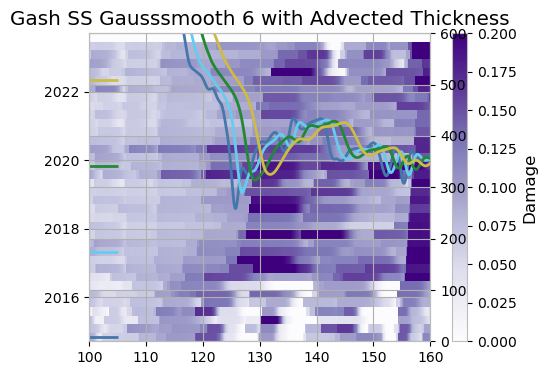

In [35]:
p = plt.pcolormesh(uxs[0], uxs[2], r_ss, vmin=0, vmax=0.2, cmap='Purples')
#plt.axvline(1278, c='k', alpha=0.1)
#plt.pcolormesh(np.isnan(exxs[1]), cmap=colors.ListedColormap([(0,0,0,0), (0,0,0,.2)]));
plt.colorbar(p, label='Damage')
plt.xlim([100, 160])

for t, c in zip(ts[::10], ['#4477aa', '#66ccee', '#228833', '#ccbb44', '#ee6677', '#aa3377', '#bbbbbb']):
    plt.hlines(t,100, 105, color=c)
plt.twinx()
plt.plot(uxs[0][0], thks_over_time[::10].T)
plt.ylim([0,600])
plt.title('Gash SS Gausssmooth 6 with Advected Thickness')

if SAVEOUTPUT:
    plt.savefig('../figs/gash-A_2p5en17-mdot_0-alpha_0-gausssmooth6-steadystate-advect_thick.png', dpi=600)

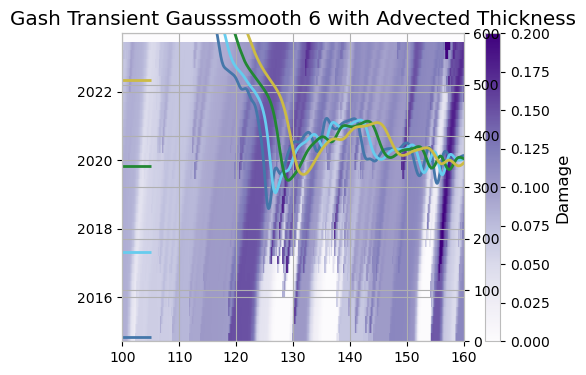

In [36]:
p = plt.pcolormesh(uxs[0], uxs[2], r_t, vmin=0, vmax=0.2, cmap='Purples')
#plt.axvline(1278, c='k', alpha=0.1)
#plt.pcolormesh(np.isnan(exxs[1]), cmap=colors.ListedColormap([(0,0,0,0), (0,0,0,.2)]));
plt.colorbar(p, label='Damage')
plt.xlim([100, 160])

for t, c in zip(ts[::10], ['#4477aa', '#66ccee', '#228833', '#ccbb44', '#ee6677', '#aa3377', '#bbbbbb']):
    plt.hlines(t,100, 105, color=c)

plt.twinx()
plt.plot(uxs[0][0], thks_over_time[::10].T)
plt.ylim([0,600])
plt.title('Gash Transient Gausssmooth 6 with Advected Thickness')
if SAVEOUTPUT:
    plt.savefig('../figs/gash-A_2p5en17-mdot_0-alpha_0-gausssmooth6-transient-advect_thick.png', dpi=600)

In [37]:
pts = flowlines['gash']

exxs = read_adrian_hov('../data/hov_thwaites_new/hov.teis-gash.quarterly_strains.txt').T.reshape((3,49,-1))
exxs = collapse_duplicate_times(exxs)
exxs_filled = astropy.convolution.interpolate_replace_nans(exxs[1], kernel=astropy.convolution.Gaussian2DKernel(2))

uxs = read_adrian_hov('../data/hov_thwaites_new/hov.teis-gash.quarterly_speeds.txt').T.reshape((3,49,-1))
uxs = collapse_duplicate_times(uxs)
uxs_filled = astropy.convolution.interpolate_replace_nans(uxs[1], kernel=astropy.convolution.Gaussian2DKernel(2))+1e-10

# Distances in km
xs = uxs[0][0]
# Times in decimal year
ts = uxs[2][:,0]

thks = np.genfromtxt('../data/hov_thwaites_new/Gash_Hofmoeller_geometry.csv', delimiter=',', skip_header=1)[:,4]
thks_smooth = astropy.convolution.convolve(thks, kernel=astropy.convolution.Gaussian1DKernel(2))

thks_over_time = evolve_thickess(thks_smooth, uxs_filled, exxs_filled, xs, ts)

/tmp/ipykernel_7309/1204541251.py:26: RuntimeWarning: Mean of empty slice
  duplicate_time_nanmean = np.nanmean(np.vstack([arr[1][i], arr[1][i+1]]), axis=0)


In [38]:
dx = 0.1

# Steady state damages and Nye zero-stress damages
r_ss = np.zeros_like(thks_over_time)
rn_ss = np.zeros_like(thks_over_time)
# Incremented damages and Nye zero-stress damages
rn_t = np.zeros_like(thks_over_time)
r_t = np.zeros_like(thks_over_time)

# Iterate through timeseries
for i, deltat in enumerate(np.diff(ts)):
    # Compute the steady-state damage in the new thickness configuration, etc.
    r_ss[i], rn_ss[i] = flowline_damage(exxs_filled[i], thks_over_time[i],0,
                    uxs_filled[i], 0,
                    atol=1e-7, return_conv=False)


    # Timeseries (non steady state) damage evolution
    # On first time step, set initial incremented damage with SS
    if i==0: 
        r_t[0] = r_ss[0]
        rn_t[0] = rn_ss[0]
        continue

    # Use midpoint rule through timestep
    ux_mid = (uxs_filled[i] + uxs_filled[i-1])/2
    exx_mid = (exxs_filled[i] + exxs_filled[i-1])/2
    thk_mid = (thks_over_time[i] + thks_over_time[i-1])/2
    # 
    r_intermediate = r_t[i-1].copy()
    dt_cfl = np.min(dx/(ux_mid*365.25/1000)/2.) # CFL Criterion
    # number of steps consistent with CFL Criterion
    isteps = np.ceil(deltat / dt_cfl)
    # timestep consistent with CFL Criterion
    dt = deltat / isteps
    assert dt <= dt_cfl
    for j in range(int(isteps)):
        dr, rn_t[i] = bassis_ma_source(r_intermediate, exx_mid, thk_mid,0,
                            ux_mid, 0)
        r_intermediate = np.maximum(rn_t[i], np.minimum(r_intermediate+dr*dt,1))
    r_t[i] = r_intermediate.copy()

if SAVEOUTPUT:
    np.savetxt('../results/gash-A_2p5en17-mdot_0-alpha_0-hovthick_gausssmooth2-advect_thick.txt', 
           np.dstack([uxs[0],uxs[2],r_ss,r_t,rn_ss,thks_over_time]).transpose((2,0,1)).reshape((6,-1)).T,
           header='Date\tDistance\tSteadyStateDam\tTransientDam\tNyeDamage\tThickness')


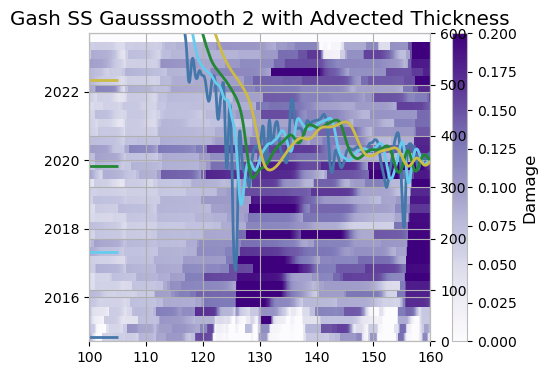

In [39]:
p = plt.pcolormesh(uxs[0], uxs[2], r_ss, vmin=0, vmax=0.2, cmap='Purples')
#plt.axvline(1278, c='k', alpha=0.1)
#plt.pcolormesh(np.isnan(exxs[1]), cmap=colors.ListedColormap([(0,0,0,0), (0,0,0,.2)]));
plt.colorbar(p, label='Damage')
plt.xlim([100, 160])

for t, c in zip(ts[::10], ['#4477aa', '#66ccee', '#228833', '#ccbb44', '#ee6677', '#aa3377', '#bbbbbb']):
    plt.hlines(t,100, 105, color=c)
plt.twinx()
plt.plot(uxs[0][0], thks_over_time[::10].T)
plt.ylim([0,600])
plt.title('Gash SS Gausssmooth 2 with Advected Thickness')

if SAVEOUTPUT:
    plt.savefig('../figs/gash-A_2p5en17-mdot_0-alpha_0-gausssmooth2-steadystate-advect_thick.png', dpi=600)

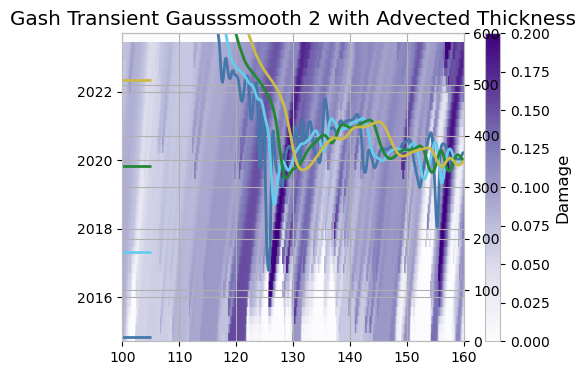

In [40]:
p = plt.pcolormesh(uxs[0], uxs[2], r_t, vmin=0, vmax=0.2, cmap='Purples')
#plt.axvline(1278, c='k', alpha=0.1)
#plt.pcolormesh(np.isnan(exxs[1]), cmap=colors.ListedColormap([(0,0,0,0), (0,0,0,.2)]));
plt.colorbar(p, label='Damage')
plt.xlim([100, 160])

for t, c in zip(ts[::10], ['#4477aa', '#66ccee', '#228833', '#ccbb44', '#ee6677', '#aa3377', '#bbbbbb']):
    plt.hlines(t,100, 105, color=c)

plt.twinx()
plt.plot(uxs[0][0], thks_over_time[::10].T)
plt.ylim([0,600])
plt.title('Gash Transient Gausssmooth 2 with Advected Thickness')
if SAVEOUTPUT:
    plt.savefig('../figs/gash-A_2p5en17-mdot_0-alpha_0-gausssmooth2-transient-advect_thick.png', dpi=600)

### Incorporating melt

In the following cells, we interpolate the Adusimilli , et al 2020 average meltrates for 1994-2018 to the flowlines, and incorporate them into the thickness advection and the damage modeling. You will need to download the Adusumilli, et al 2020 dataset from https://library.ucsd.edu/dc/object/bb0448974g into the data/adusumilli2020 directory to perform this computation.

#### Loading melt-rates

In [41]:
f = h5py.File('../data/adusumilli2020/ANT_iceshelf_height_changes_RA_1994_2018_v0.h5', 'r')

In [42]:
x_adusumilli = f['x'][:].flatten()
y_adusumilli = f['y'][:].flatten()

In [43]:
melt_thw = f['w_b'][3705:4006, 2199:2564]

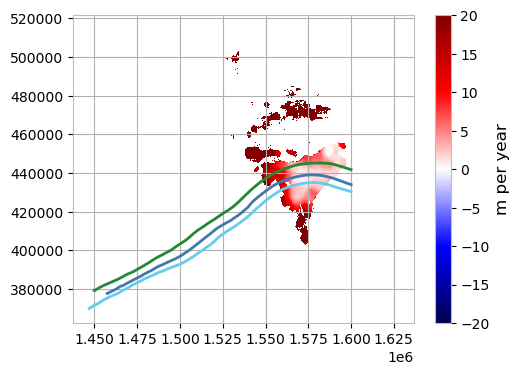

In [44]:
plt.pcolormesh(-x_adusumilli[2199:2564], -y_adusumilli[3705:4006], melt_thw, cmap='seismic', vmin=-20, vmax=20); plt.colorbar(label='m per year')

for key, pts in flowlines.items():
    plt.plot(*pts)

In [45]:
avg_melt_inter = RectBivariateSpline(-x_adusumilli[2199:2564][::-1], -y_adusumilli[3705:4006][::-1], 
                                     np.nan_to_num(melt_thw,0).T[::-1,::-1])


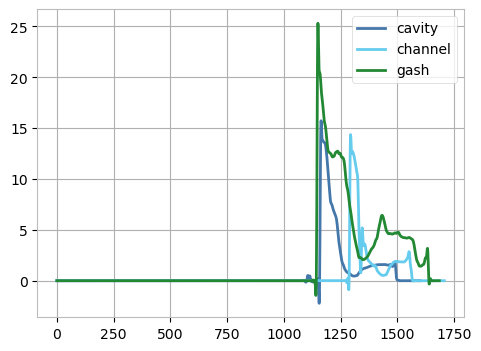

In [46]:
for key, val in flowlines.items():
    plt.plot(avg_melt_inter.ev(*val), label=key)

plt.legend()

#### Cavity

In [47]:
pts = flowlines['cavity']

exxs = read_adrian_hov('../data/hov_thwaites_new/hov.teis-cavity.quarterly_strains.txt').T.reshape((3,49,-1))
exxs = collapse_duplicate_times(exxs)
exxs_filled = astropy.convolution.interpolate_replace_nans(exxs[1], kernel=astropy.convolution.Gaussian2DKernel(6))

uxs = read_adrian_hov('../data/hov_thwaites_new/hov.teis-cavity.quarterly_speeds.txt').T.reshape((3,49,-1))
uxs = collapse_duplicate_times(uxs)
uxs_filled = astropy.convolution.interpolate_replace_nans(uxs[1], kernel=astropy.convolution.Gaussian2DKernel(6))

thks = np.genfromtxt('../data/hov_thwaites_new/CavC_Hofmoeller_geometry.csv', delimiter=',', skip_header=1)[:,4]
thks_smooth = astropy.convolution.convolve(thks, kernel=astropy.convolution.Gaussian1DKernel(6))

# Distances in km
xs = uxs[0][0]
# Times in decimal year
ts = uxs[2][:,0]

melt = avg_melt_inter.ev(*pts)

/tmp/ipykernel_7309/1204541251.py:26: RuntimeWarning: Mean of empty slice
  duplicate_time_nanmean = np.nanmean(np.vstack([arr[1][i], arr[1][i+1]]), axis=0)


In [48]:
thks_over_time = evolve_thickess(thks_smooth, uxs_filled, exxs_filled, xs, ts)

In [49]:
thks_over_time_melt = evolve_thickess(thks_smooth, uxs_filled, exxs_filled, xs, ts, melt=melt)

(110.0, 160.0)

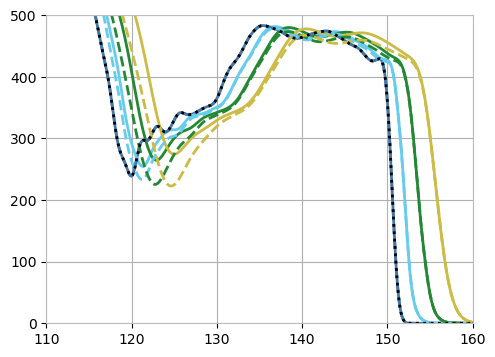

In [50]:
plt.plot(xs, thks_over_time[::10].T)


plt.gca().set_prop_cycle(None)

plt.plot(xs, thks_over_time_melt[::10].T, ls='--')


plt.plot(xs, thks_smooth, ls=':', c='k')
plt.ylim([0,500])
plt.xlim([110,160])


In [51]:
pts = flowlines['cavity']

exxs = read_adrian_hov('../data/hov_thwaites_new/hov.teis-cavity.quarterly_strains.txt').T.reshape((3,49,-1))
exxs = collapse_duplicate_times(exxs)
exxs_filled = astropy.convolution.interpolate_replace_nans(exxs[1], kernel=astropy.convolution.Gaussian2DKernel(6))

uxs = read_adrian_hov('../data/hov_thwaites_new/hov.teis-cavity.quarterly_speeds.txt').T.reshape((3,49,-1))
uxs = collapse_duplicate_times(uxs)
uxs_filled = astropy.convolution.interpolate_replace_nans(uxs[1], kernel=astropy.convolution.Gaussian2DKernel(6))

# Distances in km
xs = uxs[0][0]
# Times in decimal year
ts = uxs[2][:,0]

thks = np.genfromtxt('../data/hov_thwaites_new/CavC_Hofmoeller_geometry.csv', delimiter=',', skip_header=1)[:,4]
thks_smooth = astropy.convolution.convolve(thks, kernel=astropy.convolution.Gaussian1DKernel(6))

melt = avg_melt_inter.ev(*pts)
if SAVEOUTPUT:
    np.savetxt('../results/CavCHofmoeller_melt.txt', melt,
          header='Adusumilli et al 2020 melt rate interpolated to CavC')

thks_over_time = evolve_thickess(thks_smooth, uxs_filled, exxs_filled, xs, ts, melt=melt)

/tmp/ipykernel_7309/1204541251.py:26: RuntimeWarning: Mean of empty slice
  duplicate_time_nanmean = np.nanmean(np.vstack([arr[1][i], arr[1][i+1]]), axis=0)


In [52]:
dx = 0.1

# Steady state damages and Nye zero-stress damages
r_ss = np.zeros_like(thks_over_time)
rn_ss = np.zeros_like(thks_over_time)
# Incremented damages and Nye zero-stress damages
rn_t = np.zeros_like(thks_over_time)
r_t = np.zeros_like(thks_over_time)

# Iterate through timeseries
for i, deltat in enumerate(np.diff(ts)):
    # Compute the steady-state damage in the new thickness configuration, etc.
    r_ss[i], rn_ss[i] = flowline_damage(exxs_filled[i], thks_over_time_melt[i],0,
                    uxs_filled[i],  mdots=melt,
                    atol=1e-7, return_conv=False,)


    # Timeseries (non steady state) damage evolution
    # On first time step, set initial incremented damage with SS
    if i==0: 
        r_t[0] = r_ss[0]
        rn_t[0] = rn_ss[0]
        continue

    # Use midpoint rule through timestep
    ux_mid = (uxs_filled[i] + uxs_filled[i-1])/2
    exx_mid = (exxs_filled[i] + exxs_filled[i-1])/2
    thk_mid = (thks_over_time_melt[i] + thks_over_time_melt[i-1])/2
    # 
    r_intermediate = r_t[i-1].copy()
    dt_cfl = np.min(dx/(ux_mid*365.25/1000)/2.) # CFL Criterion
    # number of steps consistent with CFL Criterion
    isteps = np.ceil(deltat / dt_cfl)
    # timestep consistent with CFL Criterion
    dt = deltat / isteps
    assert dt <= dt_cfl
    for j in range(int(isteps)):
        dr, rn_t[i] = bassis_ma_source(r_intermediate, exx_mid, thk_mid,0,
                            ux_mid, mdots=melt)
        r_intermediate = np.maximum(rn_t[i], np.minimum(r_intermediate+dr*dt,1))
    r_t[i] = r_intermediate.copy()

if SAVEOUTPUT:
    np.savetxt('../results/cavity-A_2p5en17-mdot_adum2020-alpha_0-hovthick_gausssmooth6-advect_thick.txt', 
           np.dstack([uxs[0],uxs[2],r_ss,r_t,rn_ss,thks_over_time_melt]).transpose((2,0,1)).reshape((6,-1)).T,
           header='Date\tDistance\tSteadyStateDam\tTransientDam\tNyeDamage\tThickness')


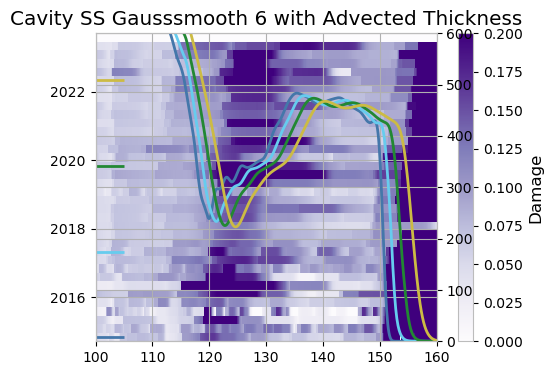

In [53]:
p = plt.pcolormesh(uxs[0], uxs[2], r_ss, vmin=0, vmax=0.2, cmap='Purples')
#plt.axvline(1278, c='k', alpha=0.1)
#plt.pcolormesh(np.isnan(exxs[1]), cmap=colors.ListedColormap([(0,0,0,0), (0,0,0,.2)]));
plt.colorbar(p, label='Damage')
plt.xlim([100, 160])

for t, c in zip(ts[::10], ['#4477aa', '#66ccee', '#228833', '#ccbb44', '#ee6677', '#aa3377', '#bbbbbb']):
    plt.hlines(t,100, 105, color=c)
plt.twinx()
plt.plot(uxs[0][0], thks_over_time_melt[::10].T)
plt.ylim([0,600])
plt.title('Cavity SS Gausssmooth 6 with Advected Thickness')

if SAVEOUTPUT:
    plt.savefig('../figs/cavity-A_2p5en17-mdot_adum2020-alpha_0-gausssmooth6-steadystate-advect_thick.png', dpi=600)

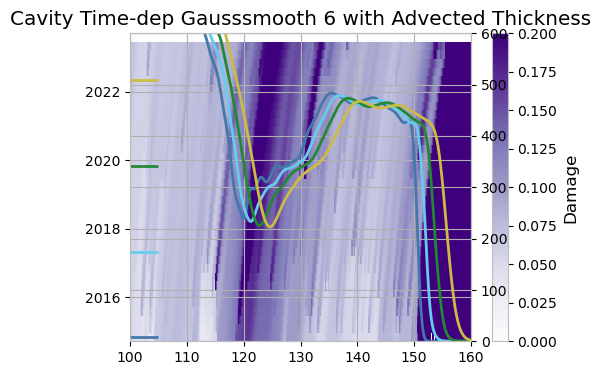

In [54]:
p = plt.pcolormesh(uxs[0], uxs[2], r_t, vmin=0, vmax=0.2, cmap='Purples')
#plt.axvline(1278, c='k', alpha=0.1)
#plt.pcolormesh(np.isnan(exxs[1]), cmap=colors.ListedColormap([(0,0,0,0), (0,0,0,.2)]));
plt.colorbar(p, label='Damage')
plt.xlim([100, 160])

for t, c in zip(ts[::10], ['#4477aa', '#66ccee', '#228833', '#ccbb44', '#ee6677', '#aa3377', '#bbbbbb']):
    plt.hlines(t,100, 105, color=c)

plt.twinx()
plt.plot(uxs[0][0], thks_over_time_melt[::10].T)
plt.ylim([0,600])
plt.title('Cavity Time-dep Gausssmooth 6 with Advected Thickness')
if SAVEOUTPUT:
    plt.savefig('../figs/cavity-A_2p5en17-mdot_adum2020-alpha_0-gausssmooth6-transient-advect_thick.png', dpi=600)

#### Channel

In [55]:
pts = flowlines['channel']

exxs = read_adrian_hov('../data/hov_thwaites_new/hov.teis-channel.quarterly_strains.txt').T.reshape((3,49,-1))
exxs = collapse_duplicate_times(exxs)
exxs_filled = astropy.convolution.interpolate_replace_nans(exxs[1], kernel=astropy.convolution.Gaussian2DKernel(6))

uxs = read_adrian_hov('../data/hov_thwaites_new/hov.teis-channel.quarterly_speeds.txt').T.reshape((3,49,-1))
uxs = collapse_duplicate_times(uxs)
uxs_filled = astropy.convolution.interpolate_replace_nans(uxs[1], kernel=astropy.convolution.Gaussian2DKernel(6))

# Distances in km
xs = uxs[0][0]
# Times in decimal year
ts = uxs[2][:,0]

thks = np.genfromtxt('../data/hov_thwaites_new/ChaC_Hofmoeller_geometry.csv', delimiter=',', skip_header=1)[:,4]
thks_smooth = astropy.convolution.convolve(thks, kernel=astropy.convolution.Gaussian1DKernel(6))

melt = avg_melt_inter.ev(*pts)
if SAVEOUTPUT:
    np.savetxt('../results/melt/ChaC_Hofmoeller_melt.txt', melt,
          header='Adusumilli et al 2020 melt rate interpolated to ChaC_')

thks_over_time = evolve_thickess(thks_smooth, uxs_filled, exxs_filled, xs, ts, melt=melt)

/tmp/ipykernel_7309/1204541251.py:26: RuntimeWarning: Mean of empty slice
  duplicate_time_nanmean = np.nanmean(np.vstack([arr[1][i], arr[1][i+1]]), axis=0)


In [56]:
dx = 0.1

# Steady state damages and Nye zero-stress damages
r_ss = np.zeros_like(thks_over_time)
rn_ss = np.zeros_like(thks_over_time)
# Incremented damages and Nye zero-stress damages
rn_t = np.zeros_like(thks_over_time)
r_t = np.zeros_like(thks_over_time)

# Iterate through timeseries
for i, deltat in enumerate(np.diff(ts)):
    # Compute the steady-state damage in the new thickness configuration, etc.
    r_ss[i], rn_ss[i] = flowline_damage(exxs_filled[i], thks_over_time[i],0,
                    uxs_filled[i],  mdots=melt,
                    atol=1e-7, return_conv=False)


    # Timeseries (non steady state) damage evolution
    # On first time step, set initial incremented damage with SS
    if i==0: 
        r_t[0] = r_ss[0]
        rn_t[0] = rn_ss[0]
        continue

    # Use midpoint rule through timestep
    ux_mid = (uxs_filled[i] + uxs_filled[i-1])/2
    exx_mid = (exxs_filled[i] + exxs_filled[i-1])/2
    thk_mid = (thks_over_time[i] + thks_over_time[i-1])/2
    # 
    r_intermediate = r_t[i-1].copy()
    dt_cfl = np.min(dx/(ux_mid*365.25/1000)/2.) # CFL Criterion
    # number of steps consistent with CFL Criterion
    isteps = np.ceil(deltat / dt_cfl)
    # timestep consistent with CFL Criterion
    dt = deltat / isteps
    assert dt <= dt_cfl
    for j in range(int(isteps)):
        dr, rn_t[i] = bassis_ma_source(r_intermediate, exx_mid, thk_mid,0,
                            ux_mid,  mdots=melt)
        r_intermediate = np.maximum(rn_t[i], np.minimum(r_intermediate+dr*dt,1))
    r_t[i] = r_intermediate.copy()

if SAVEOUTPUT:
    np.savetxt('../results/channel-A_2p5en17-mdot_adum2020-alpha_0-hovthick_gausssmooth6-advect_thick.txt', 
           np.dstack([uxs[0],uxs[2],r_ss,r_t,rn_ss,thks_over_time]).transpose((2,0,1)).reshape((6,-1)).T,
           header='Date\tDistance\tSteadyStateDam\tTransientDam\tNyeDamage\tThickness')


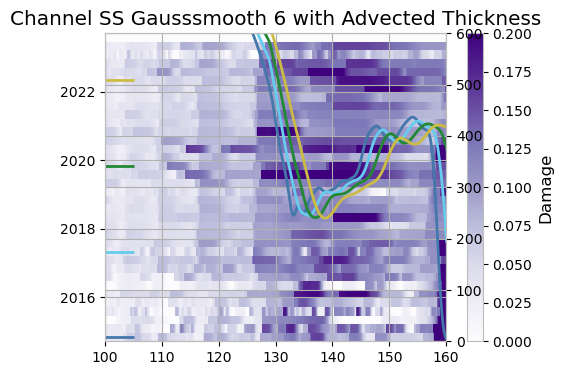

In [57]:
p = plt.pcolormesh(uxs[0], uxs[2], r_ss, vmin=0, vmax=0.2, cmap='Purples')
#plt.axvline(1278, c='k', alpha=0.1)
#plt.pcolormesh(np.isnan(exxs[1]), cmap=colors.ListedColormap([(0,0,0,0), (0,0,0,.2)]));
plt.colorbar(p, label='Damage')
plt.xlim([100, 160])

for t, c in zip(ts[::10], ['#4477aa', '#66ccee', '#228833', '#ccbb44', '#ee6677', '#aa3377', '#bbbbbb']):
    plt.hlines(t,100, 105, color=c)
plt.twinx()
plt.plot(uxs[0][0], thks_over_time[::10].T)
plt.ylim([0,600])
plt.title('Channel SS Gausssmooth 6 with Advected Thickness')

if SAVEOUTPUT:
    plt.savefig('../figs/channel-A_2p5en17-mdot_adum2020-alpha_0-gausssmooth6-steadystate-advect_thick.png', dpi=600)

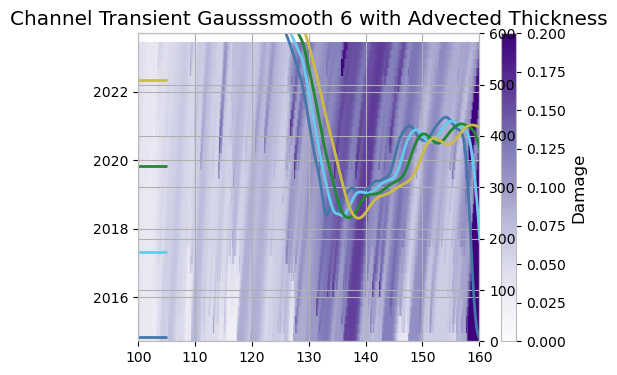

In [58]:
p = plt.pcolormesh(uxs[0], uxs[2], r_t, vmin=0, vmax=0.2, cmap='Purples')
#plt.axvline(1278, c='k', alpha=0.1)
#plt.pcolormesh(np.isnan(exxs[1]), cmap=colors.ListedColormap([(0,0,0,0), (0,0,0,.2)]));
plt.colorbar(p, label='Damage')
plt.xlim([100, 160])

for t, c in zip(ts[::10], ['#4477aa', '#66ccee', '#228833', '#ccbb44', '#ee6677', '#aa3377', '#bbbbbb']):
    plt.hlines(t,100, 105, color=c)

plt.twinx()
plt.plot(uxs[0][0], thks_over_time[::10].T)
plt.ylim([0,600])
plt.title('Channel Transient Gausssmooth 6 with Advected Thickness')
if SAVEOUTPUT:
    plt.savefig('../figs/channel-A_2p5en17-mdot_adum2020-alpha_0-gausssmooth6-transient-advect_thick.png', dpi=600)

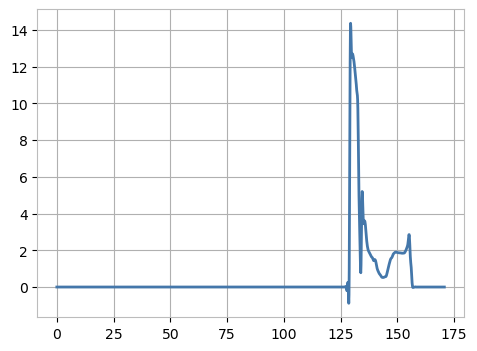

In [59]:
plt.plot(xs,melt)

#### Gash

In [60]:
pts = flowlines['gash']

exxs = read_adrian_hov('../data/hov_thwaites_new/hov.teis-gash.quarterly_strains.txt').T.reshape((3,49,-1))
exxs = collapse_duplicate_times(exxs)
exxs_filled = astropy.convolution.interpolate_replace_nans(exxs[1], kernel=astropy.convolution.Gaussian2DKernel(6))

uxs = read_adrian_hov('../data/hov_thwaites_new/hov.teis-gash.quarterly_speeds.txt').T.reshape((3,49,-1))
uxs = collapse_duplicate_times(uxs)
uxs_filled = astropy.convolution.interpolate_replace_nans(uxs[1], kernel=astropy.convolution.Gaussian2DKernel(6))

# Distances in km
xs = uxs[0][0]
# Times in decimal year
ts = uxs[2][:,0]

thks = np.genfromtxt('../data/hov_thwaites_new/Gash_Hofmoeller_geometry.csv', delimiter=',', skip_header=1)[:,4]
thks_smooth = astropy.convolution.convolve(thks, kernel=astropy.convolution.Gaussian1DKernel(6))

melt = avg_melt_inter.ev(*pts)
if SAVEOUTPUT:
    np.savetxt('../results/melt/GashHofmoeller_melt.txt', melt,
          header='Adusumilli et al 2020 melt rate interpolated to Gash')

thks_over_time = evolve_thickess(thks_smooth, uxs_filled, exxs_filled, xs, ts, melt=melt)

/tmp/ipykernel_7309/1204541251.py:26: RuntimeWarning: Mean of empty slice
  duplicate_time_nanmean = np.nanmean(np.vstack([arr[1][i], arr[1][i+1]]), axis=0)


In [61]:
dx = 0.1

# Steady state damages and Nye zero-stress damages
r_ss = np.zeros_like(thks_over_time)
rn_ss = np.zeros_like(thks_over_time)
# Incremented damages and Nye zero-stress damages
rn_t = np.zeros_like(thks_over_time)
r_t = np.zeros_like(thks_over_time)

# Iterate through timeseries
for i, deltat in enumerate(np.diff(ts)):
    # Compute the steady-state damage in the new thickness configuration, etc.
    r_ss[i], rn_ss[i] = flowline_damage(exxs_filled[i], thks_over_time[i],0,
                    uxs_filled[i], mdots=melt,
                    atol=1e-7, return_conv=False)


    # Timeseries (non steady state) damage evolution
    # On first time step, set initial incremented damage with SS
    if i==0: 
        r_t[0] = r_ss[0]
        rn_t[0] = rn_ss[0]
        continue

    # Use midpoint rule through timestep
    ux_mid = (uxs_filled[i] + uxs_filled[i-1])/2
    exx_mid = (exxs_filled[i] + exxs_filled[i-1])/2
    thk_mid = (thks_over_time[i] + thks_over_time[i-1])/2
    # 
    r_intermediate = r_t[i-1].copy()
    dt_cfl = np.min(dx/(ux_mid*365.25/1000)/2.) # CFL Criterion
    # number of steps consistent with CFL Criterion
    isteps = np.ceil(deltat / dt_cfl)
    # timestep consistent with CFL Criterion
    dt = deltat / isteps
    assert dt <= dt_cfl
    for j in range(int(isteps)):
        dr, rn_t[i] = bassis_ma_source(r_intermediate, exx_mid, thk_mid,0,
                            ux_mid, mdots=melt)
        r_intermediate = np.maximum(rn_t[i], np.minimum(r_intermediate+dr*dt,1))
    r_t[i] = r_intermediate.copy()

if SAVEOUTPUT:
    np.savetxt('../results/gash-A_2p5en17-mdot_adum2020-alpha_0-hovthick_gausssmooth6-advect_thick.txt', 
           np.dstack([uxs[0],uxs[2],r_ss,r_t,rn_ss,thks_over_time]).transpose((2,0,1)).reshape((6,-1)).T,
           header='Date\tDistance\tSteadyStateDam\tTransientDam\tNyeDamage\tThickness')


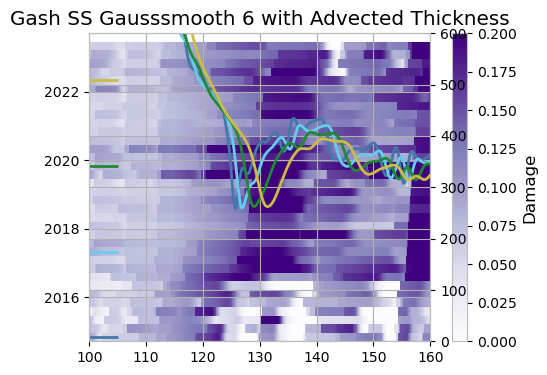

In [62]:
p = plt.pcolormesh(uxs[0], uxs[2], r_ss, vmin=0, vmax=0.2, cmap='Purples')
#plt.axvline(1278, c='k', alpha=0.1)
#plt.pcolormesh(np.isnan(exxs[1]), cmap=colors.ListedColormap([(0,0,0,0), (0,0,0,.2)]));
plt.colorbar(p, label='Damage')
plt.xlim([100, 160])

for t, c in zip(ts[::10], ['#4477aa', '#66ccee', '#228833', '#ccbb44', '#ee6677', '#aa3377', '#bbbbbb']):
    plt.hlines(t,100, 105, color=c)
plt.twinx()
plt.plot(uxs[0][0], thks_over_time[::10].T)
plt.ylim([0,600])
plt.title('Gash SS Gausssmooth 6 with Advected Thickness')

if SAVEOUTPUT:
    plt.savefig('../figs/gash-A_2p5en17-mdot_adum2020-alpha_0-gausssmooth6-steadystate-advect_thick.png', dpi=600)

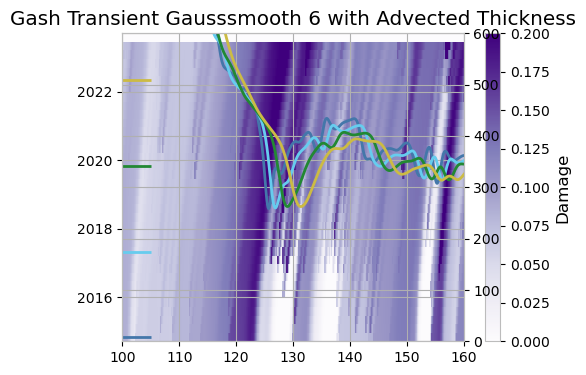

In [63]:
p = plt.pcolormesh(uxs[0], uxs[2], r_t, vmin=0, vmax=0.2, cmap='Purples')
#plt.axvline(1278, c='k', alpha=0.1)
#plt.pcolormesh(np.isnan(exxs[1]), cmap=colors.ListedColormap([(0,0,0,0), (0,0,0,.2)]));
plt.colorbar(p, label='Damage')
plt.xlim([100, 160])

for t, c in zip(ts[::10], ['#4477aa', '#66ccee', '#228833', '#ccbb44', '#ee6677', '#aa3377', '#bbbbbb']):
    plt.hlines(t,100, 105, color=c)

plt.twinx()
plt.plot(uxs[0][0], thks_over_time[::10].T)
plt.ylim([0,600])
plt.title('Gash Transient Gausssmooth 6 with Advected Thickness')
if SAVEOUTPUT:
    plt.savefig('../figs/gash-A_2p5en17-mdot_adum2020-alpha_0-gausssmooth6-transient-advect_thick.png', dpi=600)

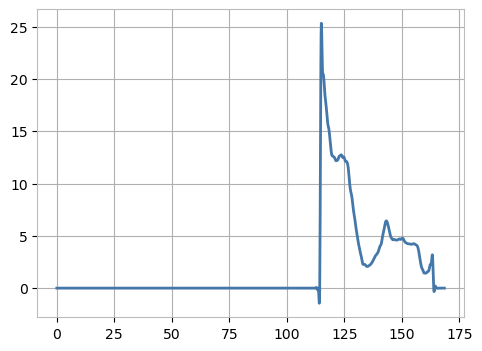

In [64]:
plt.plot(xs, melt)

# Lagrangian approach to thickness advection

The basic approach here will be to advect the mesh using the given velocities over time, essentially moving the thickness profile to new coordinates, and then interpolating back onto the initial mesh for computational consistency. This does a better job of preserving the sharp features, but makes it harder to incorporate the observed melt-rates.

In [65]:
pts = flowlines['cavity']

exxs = read_adrian_hov('../data/hov_thwaites_new/hov.teis-cavity.quarterly_strains.txt').T.reshape((3,49,-1))
exxs = collapse_duplicate_times(exxs)
exxs_filled = astropy.convolution.interpolate_replace_nans(exxs[1], kernel=astropy.convolution.Gaussian2DKernel(2))

# m/day
uxs = read_adrian_hov('../data/hov_thwaites_new/hov.teis-cavity.quarterly_speeds.txt').T.reshape((3,49,-1))
uxs = collapse_duplicate_times(uxs)
uxs_filled = astropy.convolution.interpolate_replace_nans(uxs[1], kernel=astropy.convolution.Gaussian2DKernel(2))

thks = np.genfromtxt('../data/hov_thwaites_new/CavC_Hofmoeller_geometry.csv', delimiter=',', skip_header=1)[:,4]
thks_smooth = astropy.convolution.convolve(thks, kernel=astropy.convolution.Gaussian1DKernel(2))

/tmp/ipykernel_7309/1204541251.py:26: RuntimeWarning: Mean of empty slice
  duplicate_time_nanmean = np.nanmean(np.vstack([arr[1][i], arr[1][i+1]]), axis=0)


In [66]:
# Distances in km
xs = uxs[0][0]
# Times in decimal year
ts = uxs[2][:,0]


In [67]:
def evolve_thickess_lagrange(h0, ux, xs, ts, mpd=True):
    """Evolve thicknesses using a mass-balance equation, given initial thickness,
    and strain-rates and speeds (assuming speeds are in meters per day).

    xs are distances in km
    """

    if mpd:
        # Convert m/day to km/year
        ux = ux * 365.25/1000
    
    thks = np.zeros_like(ux)
    thks[0] = h0.copy()
    for i, dt in enumerate(np.diff(ts)):
        ux_mid = (ux[i+1] + ux[i])/2
        # keep initial point fixed
        ux_mid[0] = 0

        xnew = xs + ux_mid * dt # km

        thks[i+1] = np.interp(xs, xnew, thks[i])
        
    return thks
        

In [68]:
thks_over_time = evolve_thickess(thks_smooth, uxs_filled, exxs_filled, xs, ts)
thks_over_time_lag = evolve_thickess_lagrange(thks_smooth, uxs_filled, xs, ts)

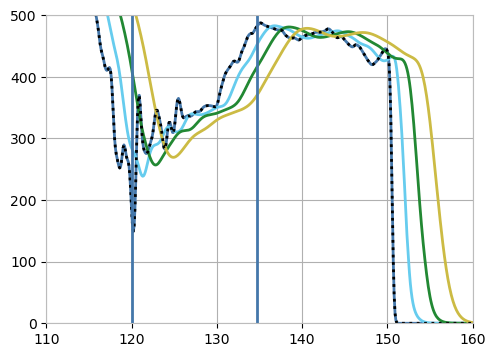

In [69]:
plt.plot(xs, thks_over_time[::10].T)
plt.plot(xs, thks_smooth, ls=':', c='k')
plt.ylim([0,500])
plt.xlim([110,160])

plt.axvline(120)
plt.axvline(134.7)

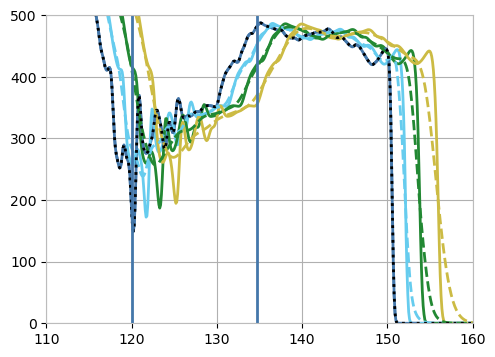

In [70]:
plt.plot(xs, thks_over_time_lag[::10].T)

plt.gca().set_prop_cycle(None)

plt.plot(xs, thks_over_time[::10].T, ls='--')

plt.plot(xs, thks_smooth, ls=':', c='k')
plt.ylim([0,500])
plt.xlim([110,160])

plt.axvline(120)
plt.axvline(134.7)

In [71]:
def flowline_damage_increment(r, ps1s_flowline, thks_flowline,alpha,
                    uxs_flowline, mdots, mpd=True):
    """
    alpha = 0 is a 1D flow
    alpha = -1 is a shear-dominated 2D flow

    uxs_flowline are assumed in m/day, converted to km/year if mpd=True
    ps1s_flowline are in per year
    """
    ps1s_flowline = ps1s_flowline + np.sign(ps1s_flowline)*1e-10 + 1e-10*(ps1s_flowline == 0)
    ps2s_flowline = alpha*ps1s_flowline

    if mpd:
        # Convert m/day to km/year
        uxs_flowline = uxs_flowline*365.25/1000
    
    rho_i = 918
    rho_w = 1028
    g = 9.81
    
    A = 2.5e-17 # Pa^-3 yr^-1
    n = 3.
    ess_flowline = np.sqrt(0.5*(ps1s_flowline**2+ps2s_flowline**2))
    pt1s_flowline = A**(-1./n)*ess_flowline**(1./n - 1)*ps1s_flowline
    
    rn = np.maximum(0, np.minimum(1, rho_i/(rho_w-rho_i)*((2+alpha)*pt1s_flowline/(rho_i*g*thks_flowline + 1e-10))))
    s0 = rho_i*(rho_w-rho_i)/rho_w*g*thks_flowline/(2*pt1s_flowline)
    
    afac = 1 + alpha + alpha**2
    nstar = 4*n*afac/(4*afac + 3*(n-1)*alpha**2)
    fac = nstar*(1-s0)*ps1s_flowline + mdots/(thks_flowline+1e-10)
    
    dx = 0.1 # km

    
    udrdx = uxs_flowline*np.r_[0, (r[1:]-r[:-1])/dx]
    dr = fac*r - udrdx

    return dr, rn

#### Cavity

In [72]:
pts = flowlines['cavity']

exxs = read_adrian_hov('../data/hov_thwaites_new/hov.teis-cavity.quarterly_strains.txt').T.reshape((3,49,-1))
exxs = collapse_duplicate_times(exxs)
exxs_filled = astropy.convolution.interpolate_replace_nans(exxs[1], kernel=astropy.convolution.Gaussian2DKernel(6))

uxs = read_adrian_hov('../data/hov_thwaites_new/hov.teis-cavity.quarterly_speeds.txt').T.reshape((3,49,-1))
uxs = collapse_duplicate_times(uxs)
uxs_filled = astropy.convolution.interpolate_replace_nans(uxs[1], kernel=astropy.convolution.Gaussian2DKernel(6))

# Distances in km
xs = uxs[0][0]
# Times in decimal year
ts = uxs[2][:,0]

thks = np.genfromtxt('../data/hov_thwaites_new/CavC_Hofmoeller_geometry.csv', delimiter=',', skip_header=1)[:,4]
thks_smooth = astropy.convolution.convolve(thks, kernel=astropy.convolution.Gaussian1DKernel(6))

thks_over_time = evolve_thickess_lagrange(thks_smooth, uxs_filled, xs, ts)

/tmp/ipykernel_7309/1204541251.py:26: RuntimeWarning: Mean of empty slice
  duplicate_time_nanmean = np.nanmean(np.vstack([arr[1][i], arr[1][i+1]]), axis=0)


In [73]:
dx = 0.1 # km

# Steady state damages and Nye zero-stress damages
r_ss = np.zeros_like(thks_over_time)
rn_ss = np.zeros_like(thks_over_time)
# Incremented damages and Nye zero-stress damages
rn_t = np.zeros_like(thks_over_time)
r_t = np.zeros_like(thks_over_time)

# Iterate through timeseries
for i, deltat in enumerate(np.diff(ts)):
    # Compute the steady-state damage in the new thickness configuration, etc.
    r_ss[i], rn_ss[i] = flowline_damage(exxs_filled[i], thks_over_time[i],0,
                    uxs_filled[i], 0,
                    atol=1e-7, return_conv=False)


    # Timeseries (non steady state) damage evolution
    # On first time step, set initial incremented damage with SS
    if i==0: 
        r_t[0] = r_ss[0]
        rn_t[0] = rn_ss[0]
        continue

    # Use midpoint rule through timestep
    ux_mid = (uxs_filled[i] + uxs_filled[i-1])/2
    exx_mid = (exxs_filled[i] + exxs_filled[i-1])/2
    thk_mid = (thks_over_time[i] + thks_over_time[i-1])/2
    # 
    r_intermediate = r_t[i-1].copy()
    dt_cfl = np.min(dx/(ux_mid*365.25/1000)/2.) # CFL Criterion, years
    # number of steps consistent with CFL Criterion
    isteps = np.ceil(deltat / dt_cfl)
    # timestep consistent with CFL Criterion
    dt = deltat / isteps
    assert dt <= dt_cfl
    for j in range(int(isteps)):
        dr, rn_t[i] = flowline_damage_increment(r_intermediate, exx_mid, thk_mid,0,
                            ux_mid, 0)
        r_intermediate = np.maximum(rn_t[i], np.minimum(r_intermediate+dr*dt,1))
    r_t[i] = r_intermediate.copy()

if SAVEOUTPUT:
    np.savetxt('../results//cavity-A_2p5en17-mdot_0-alpha_0-hovthick_gausssmooth6-advect_thick_lagrange.txt', 
           np.dstack([uxs[0],uxs[2],r_ss,r_t,rn_ss,thks_over_time]).transpose((2,0,1)).reshape((6,-1)).T,
           header='Date\tDistance\tSteadyStateDam\tTransientDam\tNyeDamage\tThickness')


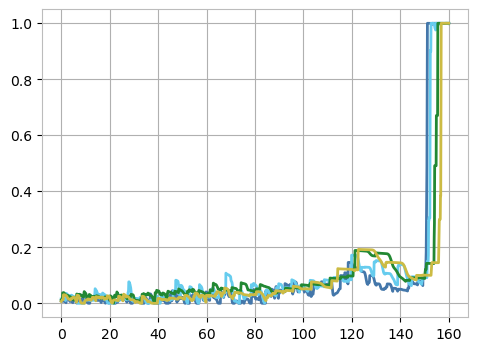

In [74]:
plt.plot(xs, r_ss[::10].T)

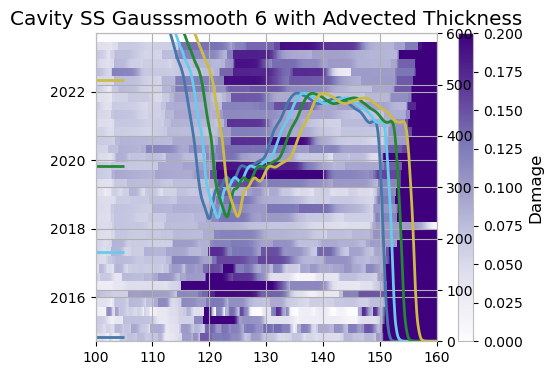

In [75]:
p = plt.pcolormesh(uxs[0], uxs[2], r_ss, vmin=0, vmax=0.2, cmap='Purples')
#plt.axvline(1278, c='k', alpha=0.1)
#plt.pcolormesh(np.isnan(exxs[1]), cmap=colors.ListedColormap([(0,0,0,0), (0,0,0,.2)]));
plt.colorbar(p, label='Damage')
plt.xlim([100, 160])

for t, c in zip(ts[::10], ['#4477aa', '#66ccee', '#228833', '#ccbb44', '#ee6677', '#aa3377', '#bbbbbb']):
    plt.hlines(t,100, 105, color=c)
plt.twinx()
plt.plot(uxs[0][0], thks_over_time[::10].T)
plt.ylim([0,600])
plt.title('Cavity SS Gausssmooth 6 with Advected Thickness')

if SAVEOUTPUT:
    plt.savefig('../figs/cavity-A_2p5en17-mdot_0-alpha_0-gausssmooth6-steadystate-advect_thick_lagrange.png', dpi=600)

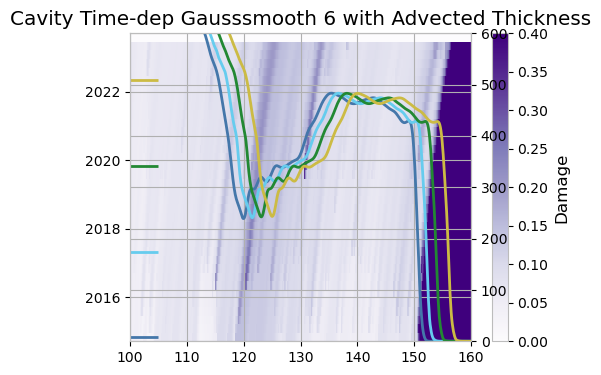

In [76]:
p = plt.pcolormesh(uxs[0], uxs[2], r_t, vmin=0, vmax=0.4, cmap='Purples')
#plt.axvline(1278, c='k', alpha=0.1)
#plt.pcolormesh(np.isnan(exxs[1]), cmap=colors.ListedColormap([(0,0,0,0), (0,0,0,.2)]));
plt.colorbar(p, label='Damage')
plt.xlim([100, 160])

for t, c in zip(ts[::10], ['#4477aa', '#66ccee', '#228833', '#ccbb44', '#ee6677', '#aa3377', '#bbbbbb']):
    plt.hlines(t,100, 105, color=c)

plt.twinx()
plt.plot(uxs[0][0], thks_over_time[::10].T)
plt.ylim([0,600])
plt.title('Cavity Time-dep Gausssmooth 6 with Advected Thickness')
if SAVEOUTPUT:
    plt.savefig('../figs/cavity-A_2p5en17-mdot_0-alpha_0-gausssmooth6-transient-advect_thick_lagrange.png', dpi=600)

#### Channel

In [77]:
pts = flowlines['channel']

exxs = read_adrian_hov('../data/hov_thwaites_new/hov.teis-channel.quarterly_strains.txt').T.reshape((3,49,-1))
exxs = collapse_duplicate_times(exxs)
exxs_filled = astropy.convolution.interpolate_replace_nans(exxs[1], kernel=astropy.convolution.Gaussian2DKernel(6))

uxs = read_adrian_hov('../data/hov_thwaites_new/hov.teis-channel.quarterly_speeds.txt').T.reshape((3,49,-1))
uxs = collapse_duplicate_times(uxs)
uxs_filled = astropy.convolution.interpolate_replace_nans(uxs[1], kernel=astropy.convolution.Gaussian2DKernel(6))

# Distances in km
xs = uxs[0][0]
# Times in decimal year
ts = uxs[2][:,0]

thks = np.genfromtxt('../data/hov_thwaites_new/ChaC_Hofmoeller_geometry.csv', delimiter=',', skip_header=1)[:,4]
thks_smooth = astropy.convolution.convolve(thks, kernel=astropy.convolution.Gaussian1DKernel(6))

thks_over_time = evolve_thickess_lagrange(thks_smooth, uxs_filled, xs, ts)

/tmp/ipykernel_7309/1204541251.py:26: RuntimeWarning: Mean of empty slice
  duplicate_time_nanmean = np.nanmean(np.vstack([arr[1][i], arr[1][i+1]]), axis=0)


In [78]:
dx = 0.1

# Steady state damages and Nye zero-stress damages
r_ss = np.zeros_like(thks_over_time)
rn_ss = np.zeros_like(thks_over_time)
# Incremented damages and Nye zero-stress damages
rn_t = np.zeros_like(thks_over_time)
r_t = np.zeros_like(thks_over_time)

# Iterate through timeseries
for i, deltat in enumerate(np.diff(ts)):
    # Compute the steady-state damage in the new thickness configuration, etc.
    r_ss[i], rn_ss[i] = flowline_damage(exxs_filled[i], thks_over_time[i],0,
                    uxs_filled[i], 0,
                    atol=1e-7, return_conv=False)


    # Timeseries (non steady state) damage evolution
    # On first time step, set initial incremented damage with SS
    if i==0: 
        r_t[0] = r_ss[0]
        rn_t[0] = rn_ss[0]
        continue

    # Use midpoint rule through timestep
    ux_mid = (uxs_filled[i] + uxs_filled[i-1])/2
    exx_mid = (exxs_filled[i] + exxs_filled[i-1])/2
    thk_mid = (thks_over_time[i] + thks_over_time[i-1])/2
    # 
    r_intermediate = r_t[i-1].copy()
    dt_cfl = np.min(dx/(ux_mid*365.25/1000)/2.) # CFL Criterion
    # number of steps consistent with CFL Criterion
    isteps = np.ceil(deltat / dt_cfl)
    # timestep consistent with CFL Criterion
    dt = deltat / isteps
    assert dt <= dt_cfl
    for j in range(int(isteps)):
        dr, rn_t[i] = flowline_damage_increment(r_intermediate, exx_mid, thk_mid,0,
                            ux_mid, 0)
        r_intermediate = np.maximum(rn_t[i], np.minimum(r_intermediate+dr*dt,1))
    r_t[i] = r_intermediate.copy()

if SAVEOUTPUT:
    np.savetxt('../results/channel-A_2p5en17-mdot_0-alpha_0-hovthick_gausssmooth6-advect_thick_lagrange.txt', 
           np.dstack([uxs[0],uxs[2],r_ss,r_t,rn_ss,thks_over_time]).transpose((2,0,1)).reshape((6,-1)).T,
           header='Date\tDistance\tSteadyStateDam\tTransientDam\tNyeDamage\tThickness')


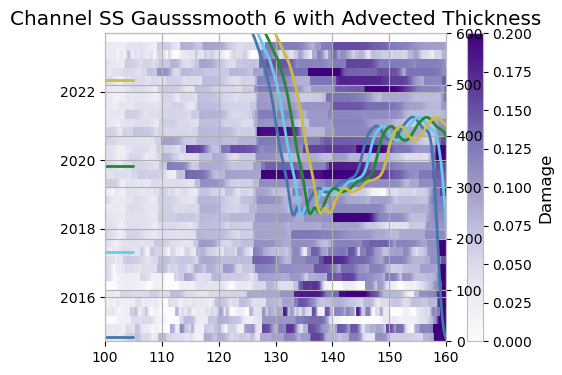

In [79]:
p = plt.pcolormesh(uxs[0], uxs[2], r_ss, vmin=0, vmax=0.2, cmap='Purples')
#plt.axvline(1278, c='k', alpha=0.1)
#plt.pcolormesh(np.isnan(exxs[1]), cmap=colors.ListedColormap([(0,0,0,0), (0,0,0,.2)]));
plt.colorbar(p, label='Damage')
plt.xlim([100, 160])

for t, c in zip(ts[::10], ['#4477aa', '#66ccee', '#228833', '#ccbb44', '#ee6677', '#aa3377', '#bbbbbb']):
    plt.hlines(t,100, 105, color=c)
plt.twinx()
plt.plot(uxs[0][0], thks_over_time[::10].T)
plt.ylim([0,600])
plt.title('Channel SS Gausssmooth 6 with Advected Thickness')

if SAVEOUTPUT:
    plt.savefig('../figs/channel-A_2p5en17-mdot_0-alpha_0-gausssmooth6-steadystate-advect_thick_lagrange.png', dpi=600)

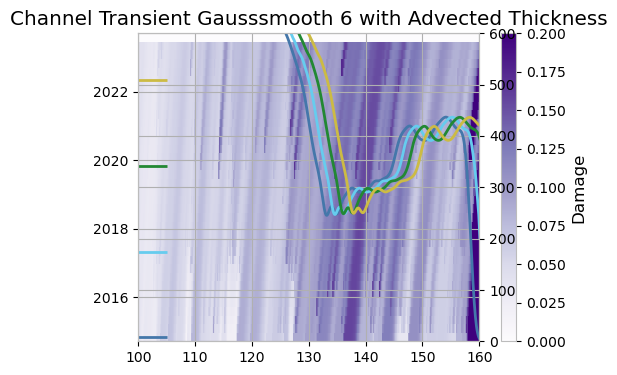

In [80]:
p = plt.pcolormesh(uxs[0], uxs[2], r_t, vmin=0, vmax=0.2, cmap='Purples')
#plt.axvline(1278, c='k', alpha=0.1)
#plt.pcolormesh(np.isnan(exxs[1]), cmap=colors.ListedColormap([(0,0,0,0), (0,0,0,.2)]));
plt.colorbar(p, label='Damage')
plt.xlim([100, 160])

for t, c in zip(ts[::10], ['#4477aa', '#66ccee', '#228833', '#ccbb44', '#ee6677', '#aa3377', '#bbbbbb']):
    plt.hlines(t,100, 105, color=c)

plt.twinx()
plt.plot(uxs[0][0], thks_over_time[::10].T)
plt.ylim([0,600])
plt.title('Channel Transient Gausssmooth 6 with Advected Thickness')
if SAVEOUTPUT:
    plt.savefig('../figs/channel-A_2p5en17-mdot_0-alpha_0-gausssmooth6-transient-advect_thick_lagrange.png', dpi=600)

#### Gash

In [81]:
pts = flowlines['gash']

exxs = read_adrian_hov('../data/hov_thwaites_new/hov.teis-gash.quarterly_strains.txt').T.reshape((3,49,-1))
exxs = collapse_duplicate_times(exxs)
exxs_filled = astropy.convolution.interpolate_replace_nans(exxs[1], kernel=astropy.convolution.Gaussian2DKernel(6))

uxs = read_adrian_hov('../data/hov_thwaites_new/hov.teis-gash.quarterly_speeds.txt').T.reshape((3,49,-1))
uxs = collapse_duplicate_times(uxs)
uxs_filled = astropy.convolution.interpolate_replace_nans(uxs[1], kernel=astropy.convolution.Gaussian2DKernel(6))

# Distances in km
xs = uxs[0][0]
# Times in decimal year
ts = uxs[2][:,0]

thks = np.genfromtxt('../data/hov_thwaites_new/Gash_Hofmoeller_geometry.csv', delimiter=',', skip_header=1)[:,4]
thks_smooth = astropy.convolution.convolve(thks, kernel=astropy.convolution.Gaussian1DKernel(6))

thks_over_time = evolve_thickess_lagrange(thks_smooth, uxs_filled, xs, ts)

/tmp/ipykernel_7309/1204541251.py:26: RuntimeWarning: Mean of empty slice
  duplicate_time_nanmean = np.nanmean(np.vstack([arr[1][i], arr[1][i+1]]), axis=0)


In [82]:
dx = 0.1

# Steady state damages and Nye zero-stress damages
r_ss = np.zeros_like(thks_over_time)
rn_ss = np.zeros_like(thks_over_time)
# Incremented damages and Nye zero-stress damages
rn_t = np.zeros_like(thks_over_time)
r_t = np.zeros_like(thks_over_time)

# Iterate through timeseries
for i, deltat in enumerate(np.diff(ts)):
    # Compute the steady-state damage in the new thickness configuration, etc.
    r_ss[i], rn_ss[i] = flowline_damage(exxs_filled[i], thks_over_time[i],0,
                    uxs_filled[i], 0,
                    atol=1e-7, return_conv=False)


    # Timeseries (non steady state) damage evolution
    # On first time step, set initial incremented damage with SS
    if i==0: 
        r_t[0] = r_ss[0]
        rn_t[0] = rn_ss[0]
        continue

    # Use midpoint rule through timestep
    ux_mid = (uxs_filled[i] + uxs_filled[i-1])/2
    exx_mid = (exxs_filled[i] + exxs_filled[i-1])/2
    thk_mid = (thks_over_time[i] + thks_over_time[i-1])/2
    # 
    r_intermediate = r_t[i-1].copy()
    dt_cfl = np.min(dx/(ux_mid*365.25/1000)/2.) # CFL Criterion
    # number of steps consistent with CFL Criterion
    isteps = np.ceil(deltat / dt_cfl)
    # timestep consistent with CFL Criterion
    dt = deltat / isteps
    assert dt <= dt_cfl
    for j in range(int(isteps)):
        dr, rn_t[i] = flowline_damage_increment(r_intermediate, exx_mid, thk_mid,0,
                            ux_mid, 0)
        r_intermediate = np.maximum(rn_t[i], np.minimum(r_intermediate+dr*dt,1))
    r_t[i] = r_intermediate.copy()

if SAVEOUTPUT:
    np.savetxt('../results/gash-A_2p5en17-mdot_0-alpha_0-hovthick_gausssmooth6-advect_thick_lagrange.txt', 
           np.dstack([uxs[0],uxs[2],r_ss,r_t,rn_ss,thks_over_time]).transpose((2,0,1)).reshape((6,-1)).T,
           header='Date\tDistance\tSteadyStateDam\tTransientDam\tNyeDamage\tThickness')


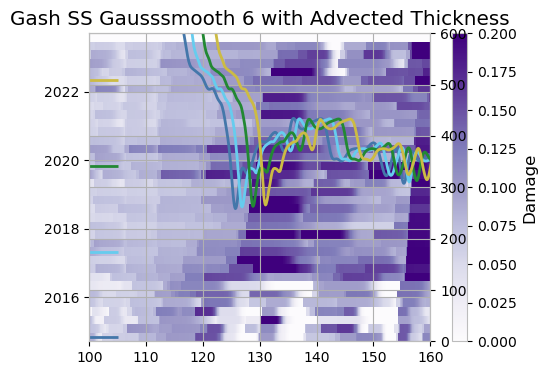

In [83]:
p = plt.pcolormesh(uxs[0], uxs[2], r_ss, vmin=0, vmax=0.2, cmap='Purples')
#plt.axvline(1278, c='k', alpha=0.1)
#plt.pcolormesh(np.isnan(exxs[1]), cmap=colors.ListedColormap([(0,0,0,0), (0,0,0,.2)]));
plt.colorbar(p, label='Damage')
plt.xlim([100, 160])

for t, c in zip(ts[::10], ['#4477aa', '#66ccee', '#228833', '#ccbb44', '#ee6677', '#aa3377', '#bbbbbb']):
    plt.hlines(t,100, 105, color=c)
plt.twinx()
plt.plot(uxs[0][0], thks_over_time[::10].T)
plt.ylim([0,600])
plt.title('Gash SS Gausssmooth 6 with Advected Thickness')

if SAVEOUTPUT:
    plt.savefig('../figs/gash-A_2p5en17-mdot_0-alpha_0-gausssmooth6-steadystate-advect_thick_lagrange.png', dpi=600)

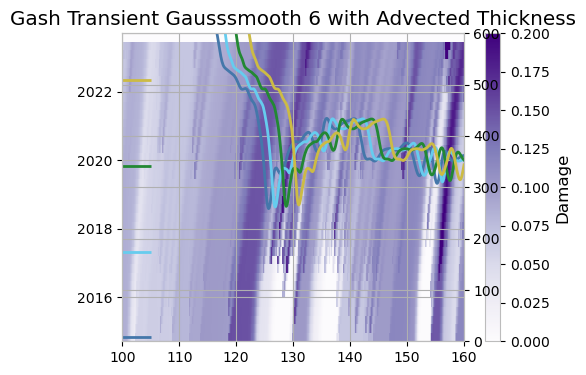

In [84]:
p = plt.pcolormesh(uxs[0], uxs[2], r_t, vmin=0, vmax=0.2, cmap='Purples')
#plt.axvline(1278, c='k', alpha=0.1)
#plt.pcolormesh(np.isnan(exxs[1]), cmap=colors.ListedColormap([(0,0,0,0), (0,0,0,.2)]));
plt.colorbar(p, label='Damage')
plt.xlim([100, 160])

for t, c in zip(ts[::10], ['#4477aa', '#66ccee', '#228833', '#ccbb44', '#ee6677', '#aa3377', '#bbbbbb']):
    plt.hlines(t,100, 105, color=c)

plt.twinx()
plt.plot(uxs[0][0], thks_over_time[::10].T)
plt.ylim([0,600])
plt.title('Gash Transient Gausssmooth 6 with Advected Thickness')
if SAVEOUTPUT:
    plt.savefig('../figs/lagrange/gash-A_2p5en17-mdot_0-alpha_0-gausssmooth6-transient-advect_thick_lagrange.png', dpi=600)

In [85]:
pts = flowlines['gash']

exxs = read_adrian_hov('../data/hov_thwaites_new/hov.teis-gash.quarterly_strains.txt').T.reshape((3,49,-1))
exxs = collapse_duplicate_times(exxs)
exxs_filled = astropy.convolution.interpolate_replace_nans(exxs[1], kernel=astropy.convolution.Gaussian2DKernel(2))

uxs = read_adrian_hov('../data/hov_thwaites_new/hov.teis-gash.quarterly_speeds.txt').T.reshape((3,49,-1))
uxs = collapse_duplicate_times(uxs)
uxs_filled = astropy.convolution.interpolate_replace_nans(uxs[1], kernel=astropy.convolution.Gaussian2DKernel(2))+1e-10

# Distances in km
xs = uxs[0][0]
# Times in decimal year
ts = uxs[2][:,0]

thks = np.genfromtxt('../data/hov_thwaites_new/Gash_Hofmoeller_geometry.csv', delimiter=',', skip_header=1)[:,4]
thks_smooth = astropy.convolution.convolve(thks, kernel=astropy.convolution.Gaussian1DKernel(2))

thks_over_time = evolve_thickess_lagrange(thks_smooth, uxs_filled, xs, ts)

/tmp/ipykernel_7309/1204541251.py:26: RuntimeWarning: Mean of empty slice
  duplicate_time_nanmean = np.nanmean(np.vstack([arr[1][i], arr[1][i+1]]), axis=0)


In [86]:
dx = 0.1

# Steady state damages and Nye zero-stress damages
r_ss = np.zeros_like(thks_over_time)
rn_ss = np.zeros_like(thks_over_time)
# Incremented damages and Nye zero-stress damages
rn_t = np.zeros_like(thks_over_time)
r_t = np.zeros_like(thks_over_time)

# Iterate through timeseries
for i, deltat in enumerate(np.diff(ts)):
    # Compute the steady-state damage in the new thickness configuration, etc.
    r_ss[i], rn_ss[i] = flowline_damage(exxs_filled[i], thks_over_time[i],0,
                    uxs_filled[i], 0,
                    atol=1e-7, return_conv=False)


    # Timeseries (non steady state) damage evolution
    # On first time step, set initial incremented damage with SS
    if i==0: 
        r_t[0] = r_ss[0]
        rn_t[0] = rn_ss[0]
        continue

    # Use midpoint rule through timestep
    ux_mid = (uxs_filled[i] + uxs_filled[i-1])/2
    exx_mid = (exxs_filled[i] + exxs_filled[i-1])/2
    thk_mid = (thks_over_time[i] + thks_over_time[i-1])/2
    # 
    r_intermediate = r_t[i-1].copy()
    dt_cfl = np.min(dx/(ux_mid*365.25/1000)/2.) # CFL Criterion
    # number of steps consistent with CFL Criterion
    isteps = np.ceil(deltat / dt_cfl)
    # timestep consistent with CFL Criterion
    dt = deltat / isteps
    assert dt <= dt_cfl
    for j in range(int(isteps)):
        dr, rn_t[i] = flowline_damage_increment(r_intermediate, exx_mid, thk_mid,0,
                            ux_mid, 0)
        r_intermediate = np.maximum(rn_t[i], np.minimum(r_intermediate+dr*dt,1))
    r_t[i] = r_intermediate.copy()

if SAVEOUTPUT:
    np.savetxt('../results/gash-A_2p5en17-mdot_0-alpha_0-hovthick_gausssmooth2-advect_thick_lagrange.txt', 
           np.dstack([uxs[0],uxs[2],r_ss,r_t,rn_ss,thks_over_time]).transpose((2,0,1)).reshape((6,-1)).T,
           header='Date\tDistance\tSteadyStateDam\tTransientDam\tNyeDamage\tThickness')


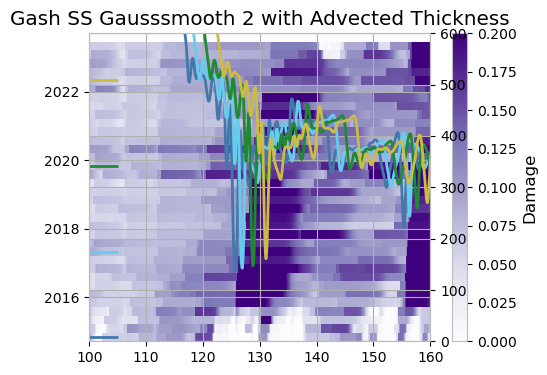

In [87]:
p = plt.pcolormesh(uxs[0], uxs[2], r_ss, vmin=0, vmax=0.2, cmap='Purples')
#plt.axvline(1278, c='k', alpha=0.1)
#plt.pcolormesh(np.isnan(exxs[1]), cmap=colors.ListedColormap([(0,0,0,0), (0,0,0,.2)]));
plt.colorbar(p, label='Damage')
plt.xlim([100, 160])

for t, c in zip(ts[::10], ['#4477aa', '#66ccee', '#228833', '#ccbb44', '#ee6677', '#aa3377', '#bbbbbb']):
    plt.hlines(t,100, 105, color=c)
plt.twinx()
plt.plot(uxs[0][0], thks_over_time[::10].T)
plt.ylim([0,600])
plt.title('Gash SS Gausssmooth 2 with Advected Thickness')

if SAVEOUTPUT:
    plt.savefig('../figs/gash-A_2p5en17-mdot_0-alpha_0-gausssmooth2-steadystate-advect_thick_lagrange.png', dpi=600)

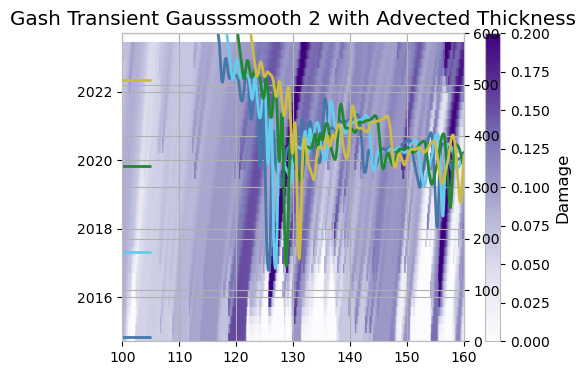

In [88]:
p = plt.pcolormesh(uxs[0], uxs[2], r_t, vmin=0, vmax=0.2, cmap='Purples')
#plt.axvline(1278, c='k', alpha=0.1)
#plt.pcolormesh(np.isnan(exxs[1]), cmap=colors.ListedColormap([(0,0,0,0), (0,0,0,.2)]));
plt.colorbar(p, label='Damage')
plt.xlim([100, 160])

for t, c in zip(ts[::10], ['#4477aa', '#66ccee', '#228833', '#ccbb44', '#ee6677', '#aa3377', '#bbbbbb']):
    plt.hlines(t,100, 105, color=c)

plt.twinx()
plt.plot(uxs[0][0], thks_over_time[::10].T)
plt.ylim([0,600])
plt.title('Gash Transient Gausssmooth 2 with Advected Thickness')
if SAVEOUTPUT:
    plt.savefig('../figs/gash-A_2p5en17-mdot_0-alpha_0-gausssmooth2-transient-advect_thick_lagrange.png', dpi=600)